In [2]:
!pip install transformers

     |████████████████████████████████| 2.5MB 10.6MB/s 
     |████████████████████████████████| 3.3MB 22.8MB/s 
     |████████████████████████████████| 901kB 33.0MB/s 


In [3]:
import numpy as np
import pandas as pd
import torch
import transformers as tfm 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

In [4]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [5]:
display(HTML(df.head(5).to_html()))

,0,1
0,"a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films",1
1,apparently reassembled from the cutting room floor of any given daytime soap,0
2,"they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",0
3,"this is a visually stunning rumination on love , memory , history and the war between art and commerce",1
4,jonathan parker 's bartleby should have been the be all end all of the modern office anomie films,1


### 3) Bert fine-tune 

In [6]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
try:
   from datasets import load_metric
except:
  !pip install datasets
  from datasets import load_metric
from transformers import TrainingArguments, Trainer


     |████████████████████████████████| 266kB 11.7MB/s 
     |████████████████████████████████| 122kB 20.0MB/s 
     |████████████████████████████████| 245kB 20.6MB/s 


In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [8]:
comedies = ["The Interview", "Get Hard", "Sex Is Zero", "Hot Fuzz", "21 Jump Street", "The Hangover", "AIRPLANE!",
            "Shaun of the Dead", "The 40-Year-Old Virgin", "Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan", 
            "The Brothers Grimsby", "Ace Ventura: Pet Detective", "Neighbors", "Dirty Grandpa", "Booksmart", "Baywatch", "GAME NIGHT", "PITCH PERFECT", ""]

actions = ["FAST & FURIOUS (2009)", "BATMAN V SUPERMAN: DAWN OF JUSTICE (2016)", "GHOST RIDER (2007)", "GREEN LANTERN (2011)", "SUICIDE SQUAD (2016)", 
           "BLADE: TRINITY (2004)", "DARK PHOENIX (2019)", "UNDERDOG (2007)", "ELEKTRA (2005)", "FANTASTIC FOUR (2015)", "MAX STEEL (2016)"]

worst_films = '''MATERIAL GIRLS (2006) 
A LITTLE BIT OF HEAVEN (2012)
FLATLINERS (2017)
MOVIE 43 (2013)
GODSEND (2003)
BUCKY LARSON: BORN TO BE A STAR (2011)
ONE FOR THE MONEY (2012)
STRATTON (2018)
NATIONAL LAMPOON'S GOLD DIGGERS (2004)
ONE MISSED CALL (2008)
BALLISTIC: ECKS VS. SEVER (2002)
THE LAST DAYS OF AMERICAN CRIME (2020)
HOT PURSUIT (2015)
THE LAST AIRBENDER (2010)
GIGLI (2003)
THE PERFECT MAN (2005)
PARANOIA (2013)
WHO'S YOUR CADDY? (2007)
SUPERCROSS (2005)
DELTA FARCE (2007)
FEARDOTCOM (2002)
ZOOM (2006)
GONE FISHIN' (1997)
PRECIOUS CARGO (2016)'''

In [17]:
worst_films_pattern = re.compile(r'(.+)\s\(\d+\)')
worst_films = worst_films_pattern.sub(f'\\1', worst_films).split('\n')
worst_films

['MATERIAL GIRLS ',
 'A LITTLE BIT OF HEAVEN',
 'FLATLINERS',
 'MOVIE 43',
 'GODSEND',
 'BUCKY LARSON: BORN TO BE A STAR',
 'ONE FOR THE MONEY',
 'STRATTON',
 "NATIONAL LAMPOON'S GOLD DIGGERS",
 'ONE MISSED CALL',
 'BALLISTIC: ECKS VS. SEVER',
 'THE LAST DAYS OF AMERICAN CRIME',
 'HOT PURSUIT',
 'THE LAST AIRBENDER',
 'GIGLI',
 'THE PERFECT MAN',
 'PARANOIA',
 "WHO'S YOUR CADDY?",
 'SUPERCROSS',
 'DELTA FARCE',
 'FEARDOTCOM',
 'ZOOM',
 "GONE FISHIN'",
 'PRECIOUS CARGO']

In [18]:
movies = """1.CITIZEN KANE (1941)
2.CASABLANCA (1942)
3.GODFATHER, THE (1972)
4.GONE WITH THE WIND (1939)
5.LAWRENCE OF ARABIA (1962)
6.WIZARD OF OZ, THE (1939)
7.GRADUATE, THE (1967)
8.ON THE WATERFRONT (1954)
9.SCHINDLER'S LIST (1993)
10.SINGIN' IN THE RAIN (1952)
11.IT'S A WONDERFUL LIFE (1946)
12.SUNSET BOULEVARD (1950)
13.BRIDGE ON THE RIVER KWAI, THE (1957)
14.SOME LIKE IT HOT (1959)
15.STAR WARS (1977)
16.ALL ABOUT EVE (1950)
17.AFRICAN QUEEN, THE (1951)
18.PSYCHO (1960)
19.CHINATOWN (1974)
20.ONE FLEW OVER THE CUCKOO'S NEST (1975)
21.GRAPES OF WRATH, THE (1940)
22.2001: A SPACE ODYSSEY (1968)
23.MALTESE FALCON, THE (1941)
24.RAGING BULL (1980)
25.E.T. THE EXTRA-TERRESTRIAL (1982)
26.DR. STRANGELOVE (1964)
27.BONNIE & CLYDE (1967)
28.APOCALYPSE NOW (1979)
29.MR. SMITH GOES TO WASHINGTON (1939)
30.TREASURE OF THE SIERRA MADRE (1948)
31.ANNIE HALL (1977)
32.GODFATHER PART II, THE (1974)
33.HIGH NOON (1952)
34.TO KILL A MOCKINGBIRD (1962)
35.IT HAPPENED ONE NIGHT (1934)
36.MIDNIGHT COWBOY (1969)
37.BEST YEARS OF OUR LIVES, THE (1946)
38.DOUBLE INDEMNITY (1944)
39.DOCTOR ZHIVAGO (1965)
40.NORTH BY NORTHWEST (1959)
41.WEST SIDE STORY (1961)
42.REAR WINDOW (1954)
43.KING KONG (1933)
44.BIRTH OF A NATION, THE (1915)
45.STREETCAR NAMED DESIRE, A (1951)
46.CLOCKWORK ORANGE, A (1971)
47.TAXI DRIVER (1976)
48.JAWS (1975)
49.SNOW WHITE & THE SEVEN DWARFS (1937)
50.BUTCH CASSIDY & THE SUNDANCE KID (1969)
51.PHILADELPHIA STORY, THE(1940)
52.FROM HERE TO ETERNITY (1953)
53.AMADEUS (1984)
54.ALL QUIET ON THE WESTERN FRONT (1930)
55.SOUND OF MUSIC, THE (1965)
56.M*A*S*H(1970)
57.THIRD MAN, THE (1949)
58.FANTASIA (1940)
59.REBEL WITHOUT A CAUSE (1955)
60.RAIDERS OF THE LOST ARK (1981)
61.VERTIGO (1958)
62.TOOTSIE (1982)
63.STAGECOACH (1939)
64.CLOSE ENCOUNTERS OF THE THIRD KIND (1977)
65.SILENCE OF THE LAMBS, THE (1991)
66.NETWORK (1976)
67.MANCHURIAN CANDIDATE, THE (1962)
68.AMERICAN IN PARIS, AN (1951)
69.SHANE (1953)
70.FRENCH CONNECTION, THE (1971)
71.FORREST GUMP (1994)
72.BEN-HUR (1959)
73.WUTHERING HEIGHTS (1939)
74.GOLD RUSH, THE (1925)
75.DANCES WITH WOLVES (1990)
76.CITY LIGHTS (1931)
77.AMERICAN GRAFFITI (1973)
78.ROCKY (1976)
79.DEER HUNTER, THE (1978)
80.WILD BUNCH, THE (1969)
81.MODERN TIMES (1936)
82.GIANT (1956)
83.PLATOON (1986)
84.FARGO (1996)
85.DUCK SOUP (1933)
86.MUTINY ON THE BOUNTY (1935)
87.FRANKENSTEIN (1931)
88.EASY RIDER (1969)
89.PATTON (1970)
90.JAZZ SINGER, THE (1927)
91.MY FAIR LADY (1964)
92.PLACE IN THE SUN, A(1951)
93.APARTMENT, THE (1960)
94.GOODFELLAS (1990)
95.PULP FICTION (1994)
96.SEARCHERS, THE (1956)
97.BRINGING UP BABY (1938)
98.UNFORGIVEN (1992)
99.GUESS WHO'S COMING TO DINNER (1967)
100. YANKEE DOODLE DANDY (1942)"""

pattern = re.compile(r'\d+\.(.+)\s(THE)*\(.+')
movies = pattern.sub(f'\\2\\1', movies)#.split('\n')
pattern = re.compile(r'(\w+)(,\s(THE))*')
movies = pattern.sub(f'\\3 \\1', movies).split('\n')
movies = [m[1:] if m[0] == ' ' else m for m in movies]

In [19]:
inds = np.random.randint(0, 100, size = 50)

len(comedies) + len(worst_films) + len(actions)
films = comedies + worst_films + actions + np.array(movies)[inds].tolist()

In [20]:
len(films)

104

In [21]:
all_reviews = []
all_labels = []
for title in films:
  reviews, labels = extract_movie_reviews(title = title, title_type = "movie", All = True, print_url = False)
  all_reviews += reviews
  all_labels += labels

Projected score: 51.298701298701296 
Projected score: 27.956989247311824 
Extraction failed: check spelling, or data format not supported on this page. Title searched was Sex Is Zero
Projected score: 91.17647058823529 
Projected score: 84.51327433628319 
Projected score: 78.33333333333333 
Projected score: 97.10144927536231 
Projected score: 91.54929577464789 
Projected score: 85.18518518518519 
Projected score: 90.54054054054053 
Projected score: 37.22627737226277 
Projected score: 49.18032786885246 
Projected score: 72.76785714285714 
Projected score: 10.869565217391305 
Projected score: 96.23655913978494 
Projected score: 17.479674796747968 
Projected score: 84.765625 
Projected score: 80.51948051948052 
Extraction failed: check spelling, or data format not supported on this page. Title searched was 
Projected score: 3.7037037037037033 
Projected score: 3.6363636363636362 
Projected score: 3.896103896103896 
Projected score: 4.49438202247191 
Projected score: 4.316546762589928 
Proj

In [23]:
#print("original % of pos reviews %4.2f:" % np.mean(np.array(all_labels)[inds]))

In [55]:
tr_size = int(len(all_reviews) * 0.3)
print(len(inds), len(all_reviews))
np.random.seed(2021)
inds = np.random.choice(np.arange(len(all_reviews)), size = tr_size, replace = False)
assert len(set(inds)) == tr_size
#df[0][inds]
#while abs(np.mean(np.array(all_labels)[inds]) - 0.5) > 0.05:
#  inds = np.random.choice(np.arange(len(all_reviews)), size = tr_size, replace = False)
#  assert len(set(inds)) == tr_size

print(f"original % of pos reviews: {np.mean(np.array(all_labels)[inds])}")

test_inds = list(set(np.arange(len(all_reviews))).difference(inds))
train_reviews = np.array(all_reviews)[inds].tolist()
train_labels = np.array(all_labels)[inds].tolist()
test_reviews = np.array(all_reviews)[test_inds].tolist()
test_labels = np.array(all_labels)[test_inds].tolist()

print(f"train % of pos reviews: {np.mean(np.array(train_labels))}")
print(f"test % of pos reviews: {np.mean(np.array(test_labels))}")

100 11823
original % of pos reviews: 0.5705019740552736
train % of pos reviews: 0.5705019740552736
test % of pos reviews: 0.5753292255648181


In [56]:
tr_size = 4000
np.random.seed(2021)
inds = np.random.choice(np.arange(len(df)), size = tr_size, replace = False)
assert len(set(inds)) == tr_size
#df[0][inds]
while abs(np.mean(df[1][inds]) - 0.5) > 0.05:
  inds = np.random.choice(np.arange(len(df)), size = tr_size, replace = False)
  assert len(set(inds)) == tr_size

np.mean(df[1][inds])

0.5145

In [57]:
#train_txt = df[0:2000][0].tolist()
train_txt = df[0][inds].tolist() + train_reviews
train_sentiment = df[1][inds].tolist() + train_labels
#train_txt, val_txt, train_sentiment, val_sentiment = train_test_split(train_txt, df[1][inds].tolist() + train_labels)

In [58]:
test_inds = set(np.arange(len(df))).difference(inds)
assert len(test_inds) == len(df) - tr_size
test_txt = df[0][test_inds].tolist() + test_reviews
test_sentiment = df[1][test_inds].tolist() + test_labels
train_encodings = tokenizer(train_txt, truncation=True, padding=True)
#val_encodings = tokenizer(val_txt, truncation=True, padding=True)
test_encodings = tokenizer(test_txt, truncation=True, padding=True)

In [59]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    #print(idx)
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_sentiment)
#val_dataset = SentimentDataset(val_encodings, val_sentiment)
test_dataset = SentimentDataset(test_encodings, test_sentiment)

In [60]:
#training_args = TrainingArguments("test_trainer")

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [61]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
trainer = Trainer(model=model, args=training_args, 
                  train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.8.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42

Step,Training Loss
10,0.684400
20,0.691700
30,0.690800
40,0.679800
50,0.676100
60,0.669000
70,0.668100
80,0.670100
90,0.654100
100,0.593000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=4720, training_loss=0.10393770769659244, metrics={'train_runtime': 412.1689, 'train_samples_per_second': 183.08, 'train_steps_per_second': 11.452, 'total_flos': 2364534925552800.0, 'train_loss': 0.10393770769659244, 'epoch': 10.0})

In [35]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    if isinstance(predictions, (tuple, list)):
      predictions = predictions[0]

    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [54]:
# # train eval 
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=train_dataset,
#     compute_metrics=compute_metrics,
# )
# trainer.evaluate()

In [21]:
# # validation eval 
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
# )
# trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


{'eval_accuracy': 0.873,
 'eval_loss': 0.9055235385894775,
 'eval_runtime': 1.6212,
 'eval_samples_per_second': 616.814,
 'eval_steps_per_second': 9.869}

In [37]:
# final test eval
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 7650
  Batch size = 64


RuntimeError: ignored

In [23]:
def review_sentiment(text, print_txt = False, print_sentiment = False):
  '''
  Input:
  text (str) -- a single line of review to be classified.
  Output:
  Prediction (int), 1 for positive review, 0 for negative.
  '''
  if print_txt:
    print(text)
  inputs = tokenizer(text, return_tensors="pt")
  inputs['input_ids'] = inputs['input_ids'].cuda()
  inputs['attention_mask'] = inputs['attention_mask'].cuda()
  outputs = model(**inputs)
  pred = torch.argmax(outputs.logits.softmax(dim=-1)).cpu().numpy().tolist()
  sentiment = "positive" if pred == 1 else "negative"
  if print_sentiment:
    print(f"is found to be a {sentiment} review with label {pred}")
  return pred

In [ ]:
#example usage
test_pred = []
for txt in test_txt: 
  test_pred.append(review_sentiment(txt))

In [ ]:
# Next step, summarization on longer reviews
# discretize prediction to 5-star reviews
# extract keys words as tags (after synonym matching -> generate word cloud)
# use key words to classify movie genre?


### 5) Downstream: Extract most salient words in commentary

#### (i). Transformers-interpret

In [24]:
pip install transformers-interpret

     |████████████████████████████████| 1.4MB 8.6MB/s 
  Created wheel for transformers-interpret: filename=transformers_interpret-0.5.2-cp37-none-any.whl size=23516 sha256=ccf68b29caa3120e65b90d4e5e6b391bc0907b727497e2f04b8b3a8ee6fa4a8d
  Stored in directory: /root/.cache/pip/wheels/b7/01/6c/eccaa6012064b234c01cf5b883c95c69f756cabadb1451a599
Successfully built transformers-interpret


In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("sampathkethineedi/industry-classification")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "sampathkethineedi/industry-classification")

# print(tokenizer, model)


In [25]:
from transformers_interpret import SequenceClassificationExplainer

sample_text = """A very classy nice restaurant. A warm welcoming, followed by an excellent service, with a lot of attention to details on order to please you."""

multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
word_attributions = multiclass_explainer(text=sample_text)

print(word_attributions)

[('[CLS]', 0.0), ('a', 0.15670387933723567), ('very', -0.05989330490317645), ('class', -0.1653399616959075), ('##y', 0.04147059383707592), ('nice', 0.1161408464116156), ('restaurant', 0.09630064901986403), ('.', -0.06462779260656724), ('a', 0.35014152727558284), ('warm', 0.15698202152179166), ('welcoming', 0.23871201133213613), (',', 0.037821639407262686), ('followed', -0.08722826632794645), ('by', -0.10427142747135308), ('an', 0.15719282071572924), ('excellent', 0.20968824270573766), ('service', 0.02939960264745271), (',', -0.0815977217282956), ('with', 0.2892430271069004), ('a', 0.23849771239556206), ('lot', -0.25261469674901466), ('of', -0.160883844332784), ('attention', 0.3743208094275987), ('to', -0.02033377974174682), ('details', 0.21468732314514333), ('on', 0.12323595899053354), ('order', -0.25043135334746314), ('to', -0.3416084409199199), ('please', -0.008946977690359854), ('you', 0.05953281469608977), ('.', -0.02091029004453601), ('[SEP]', 0.0)]


In [60]:
comments = ["amazingly lame", "remember it",  "imperfect", "painfully padded",
            "no", "overly melodramatic", "morvern rocks", "too bad", 
            "unbearably lame", 'while centered on the life experiences of a particular theatrical family , this marvelous documentary touches ever so gracefully on the entire history of the yiddish theater , both in america and israel',
            "it 's a treat a delightful , witty , improbable romantic comedy with a zippy jazzy score grant and bullock make it look as though they are having so much fun"]

In [61]:
for comment in comments:  
  word_attributions = multiclass_explainer(text=comment)
  print(word_attributions)


[('[CLS]', 0.0), ('amazingly', -0.07140848242166584), ('lame', 0.9974471558123941), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('remember', 0.7398960375719208), ('it', -0.6727212302175181), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('imperfect', 1.0), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('painfully', 0.5993210341561399), ('padded', 0.8005087744790904), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('no', 1.0), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('overly', 0.41153598491811033), ('mel', 0.11180375804890502), ('##od', 0.309728999103818), ('##rama', 0.5837797362501195), ('##tic', 0.6175817512374461), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('mor', 0.22616929245523584), ('##vern', -0.3861536760135915), ('rocks', 0.8942778033986353), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('too', 0.27628801829036065), ('bad', 0.9610748831122293), ('[SEP]', 0.0)]
[('[CLS]', 0.0), ('un', 0.29342843486991244), ('##be', 0.6496786575059603), ('##ara', 0.254893164526324), ('##bly', 0.6533228383472524), ('lame', 0.00401735767550646), ('[SEP]', 0.0)]
[('[CLS]', 0.0

In [26]:
import string 
import nltk 
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(STOPWORDS)
puncs = string.punctuation 
from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
layers = [-3, -2, -1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
def extract_key_words_simp(sentence, stop_words, top_k = 5):
  attributions = multiclass_explainer(text=sentence)
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  key_words = []

  for word, _ in attributions:
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    
    else:
      key_words.append(word)
      count_k += 1
  
  #if count_k < top_k:
  #  key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words

In [28]:
def fill_complete_word(word, all_words):
  '''
  
  '''
  visited = []
  ind = all_words.index(word)
  whole = None
  if word[:2] == '##':
    whole = word[2:]
    ind -= 1
    prev = all_words[ind]
    while prev[:2] == '##': #gather all before
      visited.append(prev)
      whole = prev[2:] + whole
      ind -= 1
      prev = all_words[ind]
    whole = prev + whole # add the very fornt (no ##)
    visited.append(prev)

  ########################################
  ## for words like sci-fi -> [sci, -, fi]
  if all_words[ind-1] == "-":
    whole = all_words[ind-2] + all_words[ind-1] + all_words[ind]
    visited.append(all_words[ind-2])
    visited.append(all_words[ind-1])

  if all_words[ind+1] == "-":
    whole = all_words[ind] + all_words[ind+1] + all_words[ind+2]
    visited.append(all_words[ind+1])
    visited.append(all_words[ind+2])
  ########################################

  ## check if needs to keep adding to end
  if whole is None: #for complete word without ##
    whole = word
  visited.append(word)
  ind = all_words.index(word) + 1 # reset to 1 after word's index and look forward
  next = all_words[ind]
  while next[:2] == '##':
    visited.append(next)
    whole += next[2:]
    ind += 1
    next = all_words[ind]
  return whole, visited

def extract_key_words(sentence, stop_words, top_k = 5, visited = None):
  sentence = re.sub(r'[^\w\s]','', sentence)
  all_words = sentence.split()
  if len(all_words) < 2 * top_k:
    print(f"Sentence of len {len(all_words)} too short for key word extraction, using whole review.")
    return all_words

  attributions = multiclass_explainer(text=sentence)
  all_words = [word for word, _ in attributions]
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  enter_count = 0
  entr_words = []
  key_words = []
  if visited is None:
    visited = []

  for word, _ in attributions:
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    if word in visited:
      continue
    else:
      enter_count += 1
      whole, _ = fill_complete_word(word, all_words)
      entr_words.append(whole)
      whole, new_visited = fill_complete_word(word, all_words)
      visited += new_visited
      key_words.append(whole)
      count_k += 1
  
  if enter_count < top_k:
    print(f"Not possible to extract {top_k} words with {enter_count} available.")
    return entr_words

  if count_k < top_k:
    key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words


def extract_key_words_with_temp(sentence, stop_words, top_k = 5, visited = None, k = 0.1):
  sentence = re.sub(r'[^\w\s]','', sentence)
  all_words = sentence.split()
  enter_count = 0
  entr_words = []

  if len(all_words) < 2 * top_k:
    print(f"Sentence of len {len(all_words)} too short for key word extraction, using whole review.")
    return all_words

  attributions = multiclass_explainer(text=sentence)
  all_words = [word for word, _ in attributions]
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  key_words = []
  if visited is None:
    visited = []

  for i, (word, score) in enumerate(attributions):
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    if word in visited:
      continue
    else:
      enter_count += 1
      whole, _ = fill_complete_word(word, all_words)
      entr_words.append(whole)

      if score > 0.4:
        ## extract whole word if we get a partial word that is selected
        whole, new_visited = fill_complete_word(word, all_words)
        visited += new_visited
        key_words.append(whole)
        count_k += 1
      
      else:
        rand = np.random.rand(1)
        if rand < log_gr_prob(i, k)/2 + score*1.5:
          whole, new_visited = fill_complete_word(word, all_words)
          visited += new_visited
          key_words.append(whole)
          count_k += 1
  
  if enter_count < top_k:
    print(f"Not possible to extract {top_k} words with {enter_count} available")
    return entr_words

  if count_k < top_k:
    key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words

def log_gr_prob(t, k = 0.1):
  '''
  Input: k, positive number, the larger the quicker the growth of prob
  '''
  return 0.4 / (1 + np.exp(-k * t))


In [ ]:
extract_key_words(train_txt[2], stop_words, 5)

['whole', 'thing', 'course', 'fairly', 'lame']

In [ ]:
train_txt[1], train_labels[1]

('not only does leblanc make one spectacularly ugly looking broad , but he appears miserable throughout as he swaggers through his scenes',
 0)

In [ ]:
extract_key_words_with_temp(train_txt[1], stop_words, 5)

['swaggers', 'spectacularly', 'miserable', 'throughout', 'one']

#### (ii). Sklearn GBT on bert embed

In [29]:
def get_word_idx(sent: str, word: str):
     return sent.split(" ").index(word)

def get_hidden_states(encoded, word_indx_in_token, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last 3 by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    with torch.no_grad():
        input_ids = encoded['input_ids'].cuda() #using GPU
        attention_mask = encoded['attention_mask'].cuda() #using GPU
        output = model(input_ids, attention_mask = attention_mask)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[word_indx_in_token]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest, mask all other ones
    word_indx_in_token = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, word_indx_in_token, model, layers)


In [92]:
# make sure to obtain correct index
sent = "I like cookies ." 
idx = get_word_idx(sent, "cookies")
encoded = tokenizer.encode_plus(sent, return_tensors="pt")
idx, encoded.word_ids()

(2, [None, 0, 1, 2, 3, None])

In [30]:
import string 
import nltk 
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')).union(STOPWORDS)
puncs = string.punctuation 
from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [31]:
from nltk.corpus import wordnet
def find_synonym(word):
  synonyms = []
  antonyms = []
  
  for syn in wordnet.synsets(word):
      for l in syn.lemmas():
          synonyms.append(l.name())
          if l.antonyms():
              antonyms.append(l.antonyms()[0].name())
    
  synonyms = set(synonyms)
  antonyms = set(antonyms)
  return synonyms, antonyms

In [ ]:
find_synonym("happy")

({'felicitous', 'glad', 'happy', 'well-chosen'}, {'unhappy'})

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores("it is absurdly, grotesquely disturbing")

{'compound': -0.5106, 'neg': 0.452, 'neu': 0.548, 'pos': 0.0}

In [ ]:
sia.polarity_scores("it is absurdly, grotesquely interesting") #correctly uses last term (adj.) to determine

{'compound': 0.4019, 'neg': 0.0, 'neu': 0.597, 'pos': 0.403}

In [ ]:
sia.polarity_scores("interesting") #raw interesting score

{'compound': 0.4019, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0}

In [ ]:
sia.polarity_scores("interesting but") #but factors in, decreased pos

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.351, 'pos': 0.649}

In [ ]:
sia.polarity_scores("it is interesting but") #it is factors into neu, compd stabilizes

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.619, 'pos': 0.381}

In [ ]:
print(sia.polarity_scores("it is interesting but grotesque"))
sia.polarity_scores("it is interesting but absurd") #no difference between last adj, OOV/all 0 for aburd/grotesque

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.684, 'pos': 0.316}

In [ ]:
print(TextBlob("happy").sentiment)
print(TextBlob("excited").sentiment)
print(TextBlob("felicitous").sentiment)
print(TextBlob("great").sentiment)
print(TextBlob("joy").sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)
Sentiment(polarity=0.375, subjectivity=0.75)
Sentiment(polarity=0.7, subjectivity=1.0)
Sentiment(polarity=0.8, subjectivity=0.75)
Sentiment(polarity=0.8, subjectivity=0.2)


In [ ]:
print(TextBlob("offensive").sentiment) 
sia.polarity_scores("offensive") #compliments the OOV

Sentiment(polarity=0.0, subjectivity=0.0)


{'compound': -0.4588, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [ ]:
list(zip(words, labels)) #using label created by average score

[('reward', 0.35016499999999995),
 ('thoughtful', 0.3836299999999999),
 ('emotional', 0.203585),
 ('movie', 0.0),
 ('experience', 0.0)]

In [33]:
nltk.download(["vader_lexicon"])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from textblob import TextBlob

def prepare_embed_and_label(corpus, first_k = None, report = False):
  """Prepare embedding and labels to be used for word sentiment classfication to 
  determine which dims of bert embed are useful here and .
        Parameters
        ----------
        corpus : {list of sentences} of length (n_samples)
            The input document that will be processed to extract useful embeddings.
        first_k : The number of sentences to process in corpus. Default: All. 
        report : whether to output a list of chosen words that are used to create the training
        embeddings. 

        Returns
        -------
        word_embed: the training embedding to be used. 
        labels: either -1 or 1, class label for each sentiment word.
        weights: a weight based on sentiment polarity by textblob and Vader
        """
  word_embed = None
  translate = {1: "pos", -1: "neg"}
  labels = []
  weights = []
  all_c_words = []
  agg_count_v = 0
  agg_count_t = 0
  mixed_polarity_words = set()

  if first_k is not None:
    limit = first_k
  else:
    limit = len(corpus)
  
  c_words = []
  for i,sent in enumerate(corpus[:limit]):
    

    for word in sent.split():
      if word in stop_words or word in puncs:
          continue

      ### Decide text polarity ###
      txt_blb_Sent = TextBlob(word).sentiment
      #print("lbl: ", txt_blb_Sent)
      txt_blb_Sent = txt_blb_Sent[0] * 0.7 + 0.3 * txt_blb_Sent[0] * txt_blb_Sent[1] #positivity * subjectivity
      
      vader_Sent = sia.polarity_scores(word)
      #print("vader: ", vader_Sent)
      vader_Pos = 1 if vader_Sent["pos"] > vader_Sent["neg"] else -1
      vader_Sent = vader_Sent["compound"] * 0. + \
                    vader_Pos * vader_Sent[translate[vader_Pos]] * 0.3
      ###
      if abs(txt_blb_Sent) > abs(vader_Sent):
        agg_count_t += 1 
      else:
        agg_count_v += 1
      ###

      #print("v_Sent", vader_Sent)
      ############################

      ### Label Creation ###
      if txt_blb_Sent * vader_Sent < 0:
        #print(f"Check inconsistent agreement for the word {word} in Sentence {i}")
        mixed_polarity_words.add(word)
        # Trust the more assertive one for now
        if abs(txt_blb_Sent) > abs(vader_Sent):
          vader_Sent *= -1 
        else:
          txt_blb_Sent *= -1
      
      if txt_blb_Sent > 0.3 or vader_Sent > 0.3:
        labels.append(1)
      elif txt_blb_Sent < -0.3 or vader_Sent < -0.3:
        labels.append(-1)
      else:
        continue 
      
      weights.append(abs((txt_blb_Sent + vader_Sent) * 0.5)) #only magnitude matters
      ############################

      idx = get_word_idx(sent, word)
      word_embedding = get_word_vector(sent, idx, tokenizer, model, layers).cpu().numpy()
      if word_embed is not None:
        word_embed = np.vstack([word_embed, word_embedding])
        c_words.append(word)
      else:
        word_embed = word_embedding
        c_words.append(word)
      
      
    #all_c_words.append(c_words)
  
  print(f"Vader > Txtblb {agg_count_v}; Txtblb > Vader {agg_count_t}")
  print(f"All mixed polarity words {mixed_polarity_words}")
  if report:
    return word_embed, labels, weights, c_words
    #return word_embed, labels, weights, list(all_c_words)
  
  return word_embed, labels, weights

  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Note:   
   1) Use above to directly get words with the most sentiment as the most salient word
   (could add regex to support plot/character/director/cast/technique critique)

   2) Otherwise:
   To fully utilize distilbert's contextualized embeddings, 
   use Tree-based to train, each column as a feature, select top 20 useful features?
   Extract words with high proba to either pos/neg class

In [ ]:
#sample word with opposite results from textblob/ sia
word = 'whimsical'
TextBlob(word).sentiment, sia.polarity_scores(word)


(Sentiment(polarity=-0.5, subjectivity=0.5),
 {'compound': 0.0772, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0})

In [ ]:
for word in mixed_polar_wrds:
  print(word)
  print(TextBlob(word).sentiment)
  print(sia.polarity_scores(word))

bizarre
Sentiment(polarity=0.4, subjectivity=0.6)
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3182}
careful
Sentiment(polarity=-0.1, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.1531}
curious
Sentiment(polarity=-0.1, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
sentimental
Sentiment(polarity=-0.25, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
delicate
Sentiment(polarity=-0.3, subjectivity=0.9)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0516}
excuse
Sentiment(polarity=-0.05, subjectivity=0.05)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0772}
ironic
Sentiment(polarity=0.2, subjectivity=0.9)
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.128}
whimsical
Sentiment(polarity=-0.5, subjectivity=0.5)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0772}
laughable
Sentiment(polarity=-0.5, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0516}
grey
Sentiment(pola

In [ ]:
len(c_words), word_embeds.shape

(971, (971, 768))

In [34]:
########################
word_embeds, labels, weights, c_words = prepare_embed_and_label(test_txt, report = True)
########################

Vader > Txtblb 25023; Txtblb > Vader 4591
All mixed polarity words {'carefully', 'whimsical', 'passionate', 'grey', 'curious', 'crushing', 'ironic', 'delicate', 'silly', 'unbelievable', 'bizarre', 'delicately', 'laughable', 'casual', 'excuse', 'controversial', 'laughably', 'careful', 'startling', 'sentimental'}


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weights = scaler.fit_transform(X = np.array(weights)[:, None]).ravel() #prevent over-shrinking weights as all are < 1

In [36]:
train_embeds, test_embeds, train_pack, test_pack = train_test_split(word_embeds, list(zip(labels, weights, c_words)))

train_labels = []
train_weights = []
train_words = []
for lbl, wt, wrd in train_pack:
  train_labels.append(lbl)
  train_weights.append(wt)
  train_words.append(wrd)

test_labels = []
test_weights = []
test_words = []
for lbl, wt, wrd in test_pack:
  test_labels.append(lbl)
  test_weights.append(wt)
  test_words.append(wrd)

# train_weights = [w for _, w, _ in train_labels]
# test_weights = [w for _, w, _ in test_labels]
# train_labels = [l for l, _, _ in train_labels]
# test_labels = [l for l, _, _ in test_labels]


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,\
                                 max_depth=2, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[1, 2, 4], 'learning_rate':[1, 0.1, 0.01], 'n_estimators':[50, 100, 200]}
opt_clf = GridSearchCV(clf, parameters)
opt_clf.fit(X=train_embeds, y=train_labels, sample_weight=train_weights)
print("best param: ", opt_clf.best_params_)
print("best score: ", opt_clf.best_score_)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_features':[5, 50, 200], 'min_samples_split':[2, 10, 20]}
opt_clf = GridSearchCV(clf, parameters)
opt_clf.fit(X=train_embeds, y=train_labels, sample_weight=train_weights)
print("best param: ", opt_clf.best_params_)
print("best score: ", opt_clf.best_score_)
#best param:  {'max_features': 200, 'min_samples_split': 20}
#best score:  0.8764383561643836

best param:  {'max_features': 200, 'min_samples_split': 20}
best score:  0.8764383561643836


In [ ]:
sum(np.array(test_labels) == clf.predict(test_embeds)) / len(test_labels)

0.9094650205761317

In [80]:
num_off = sum(np.array(test_labels) != clf.predict(test_embeds)) #num of wrongly predicted word labels
print(f"{num_off} words classified with wrong label out of {len(test_labels)} sentiment words")

26 words classified with wrong label out of 243 sentiment words


In [ ]:
print("Word | predicted label based on embedding")
list(zip(np.array(test_words)[np.array(test_labels) != clf.predict(test_embeds)], \
np.array(test_labels)[np.array(test_labels) != clf.predict(test_embeds)]))

Word | predicted label based on embedding


[('laughable', -1),
 ('enthusiastic', 1),
 ('unfaithful', -1),
 ('dramatic', -1),
 ('popular', 1),
 ('dangerously', -1),
 ('unadulterated', 1),
 ('great', 1),
 ('overwhelming', 1),
 ('desperate', -1),
 ('true', 1),
 ('terrifying', -1),
 ('weird', -1),
 ('tedious', -1),
 ('tedious', -1),
 ('mad', -1),
 ('worst', -1),
 ('laughable', -1),
 ('strongly', 1),
 ('outstanding', 1),
 ('good', 1),
 ('bad', -1),
 ('insanely', -1),
 ('many', 1),
 ('interesting', 1),
 ('alas', -1)]

In [ ]:
# to_keep_cols = np.where(np.argsort(opt_clf.feature_importances_) < 20)[0]
# np.where(sorted_idx < 20)

In [ ]:
to_keep_cols = np.where(np.argsort(chosen.feature_importances_) < 20)[0]
np.where(sorted_idx < 20)

(array([  0, 412, 413, 414, 415, 416, 417, 418, 419, 421, 422, 423, 424,
        425, 426, 427, 428, 429, 595, 710]),)

In [ ]:
to_keep_cols = np.where(np.argsort(clf.feature_importances_) < 20)[0]
np.where(sorted_idx < 20) # fairly consistent ones chosen

(array([  0, 412, 413, 414, 415, 416, 417, 418, 419, 421, 422, 423, 424,
        425, 426, 427, 428, 429, 595, 710]),)

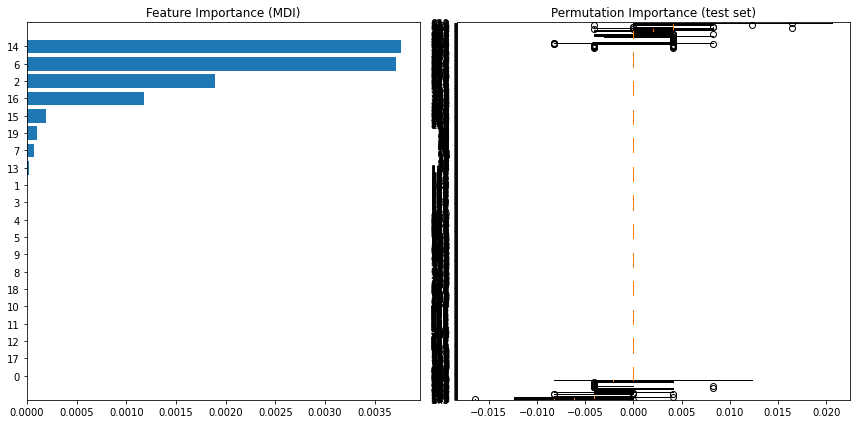

In [ ]:
# Extract embedding dims that has real impact on word positivity
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
top_k = 200
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
feature_importance = feature_importance[np.where(sorted_idx < top_k)[0]]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(top_k) + .5
#pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.arange(test_embeds.shape[1])[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(clf, test_embeds, test_labels, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.arange(test_embeds.shape[1])[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


In [ ]:
# original test score
clf.score(test_embeds, test_labels, sample_weight= test_weights) #best after some tuning

0.8875414172006284

In [ ]:
# drop embed dims? 
to_keep = np.where(np.argsort(clf.feature_importances_) < top_k)[0]
s_train_embeds = train_embeds[:, to_keep]
s_test_embeds = test_embeds[:, to_keep]
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,\
                                 max_depth=2, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)
clf.score(s_test_embeds, test_labels, sample_weight= test_weights) #best after some tuning
# No

0.813202521562404

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# # TSNE visualization, with node id on

# tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(selected_test_embeds)

# plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
# for i in range(len(tsne_emb)):
#     plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
# plt.show()



#### custom Noun Phrase Summary extraction

In [51]:
def extract_wrds(txt, clf, k = 5):
  '''
  Input: txt (a list of sentences)
  Output: Most important sentiment words in the given txt (pos and neg)
  '''
  word_embeds, labels, weights, c_words = prepare_embed_and_label(txt, report = True)
  pred = clf.predict(word_embeds) 
  acc = sum(pred == labels) / len(labels)
  print(f"Model Accuracy: {acc}")
  probs = clf.predict_proba(word_embeds)
  c_words = np.array(c_words)
  pos_wrds = c_words[np.argsort(probs[:, 0])][10:k+10] #offset to escape some obvious positive terms
  neg_wrds = c_words[np.argsort(probs[:, 1])][:k]
  return {"pos": pos_wrds.tolist(), "neg": neg_wrds.tolist()}


In [107]:
extract_wrds(test_txt[:20], clf, k = 5)

Vader > Txtblb 165; Txtblb > Vader 35
All mixed polarity words set()
Model Accuracy: 0.85


{'neg': ['cutting', 'familiar', 'desperately', 'offbeat', 'better'],
 'pos': ['original', 'many', 'sound', 'entertainingly', 'fit']}

In [169]:
inds = np.random.randint(0, 1500, size = 10)
#for sent in test_txt[:10]:
for ind in inds:
  sent = train_txt[ind]
  print(extract_np(sent))

['mildly sentimental', 'unabashedly consumerist', 'studiously inoffensive', 'completely disposable']
[]
[]
['large format film', 'well suited', 'full regalia', 'incredible imax sound']
["showtime is n't particularly assaultive"]
['truly awful', 'subject matter', 'lessons are well worth', 'many times as']
['dumb gags', 'anatomical humor']
['underventilated p re']
['undistinguished rhythm of', 'artificial suspense']
['lrb enigma rrb', 'lrb reversal of fortune']


In [250]:
# nltk.help.upenn_tagset() #for checking all pos tags
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('wordnet')
!pip install svgwrite
!pip install svgling

# 2nd way
# in extract_np
# if "not" is in sentence
# if not verb (e.g. not do, not have), save this verb
# add not to subtree that contains a np with this verb
# Otherwise
#   extract first adj closest to not
#   then for all subtree/extract np
#     add not to the np that contains the extracted adj
def parse_phrase(subtree, neg_wrd, alt = False):
  ex_words = [wrd_tag_np[0][0] for wrd_tag_np in subtree.pos()]
  
  if neg_wrd and neg_wrd in ex_words:
    ex_words = ["not"] + ex_words

  phrase = ' '.join(ex_words)
  
  if not alt:
    return phrase 
  if subtree.label() == "VJN":
    return ex_words[0] + ' ' + ex_words[-1]
  if subtree.label() == "NVJ":
    return ex_words[-1] + ' ' + ex_words[0]
    

def extract_np(sentence):
  noun_phrases = []
  chunk_grmr = ('''
      VJN: {<RB>*<JJ>+<CC>?<JJ>?.*<NNP*S*><IN>?<NNP*S*>?} # adverb adj noun
      NVJ: {<NNP*S*><IN>?<NNP*S*>?<VB[DGNPZ]>.*<RB>*.*<JJ>+<CC>?<JJ>} #noun verb adjective
      VJ: {<RB><JJ>+<CC>?<JJ>} #adv adj pairs
      VVJ: {<RB><VB[GND]>+<CC>?<JJ>}
      ''')
  chunkParser = nltk.RegexpParser(chunk_grmr)
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  tags = [tag for _, tag in tagged]
  words = [word for word, _ in tagged]
  #add = ''
  neg_wrd = ''
  if "not" in words:
    ind = words.index("not")
    #ind = [i for i, x in enumerate(sentence.split()) if x == "not"]
    #add = 'not'
  
    # use for loop if going for multiple not approach
    if words[ind+1] == "only":
      pass 

    elif tags[ind+1][:2] == "VB":
      neg_wrd = words[ind+1]

    else:
      adj_inds = [i for i, tag in enumerate(tags[ind:]) if tag[:2] == "JJ" or tag == "VBN"] #[tag for _, tag in tagged[ind:]]
      if not adj_inds:
        print("Nothing found to extract")
        pass #nth to extract from
      else:
        if ind + adj_inds[0] >= len(words):
          print(adj_inds, sentence)
        neg_wrd = words[ind + adj_inds[0]]

  tree = chunkParser.parse(tagged)
  for subtree in tree.subtrees():
    if subtree.label() in ["VJN", "NVJ", "VJ", "VVJ"]:
      #if neg_wrd:
      #  print("found neg word, processing...")
      noun_phrases.append(parse_phrase(subtree, neg_wrd))

  return noun_phrases

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [166]:
def review_sentiment(text, print_txt = False, print_sentiment = False):
  '''
  Input:
  text (str) -- a single line of review to be classified.
  Output:
  Prediction (int), 1 for positive review, 0 for negative.
  '''
  if print_txt:
    print(text)
  
  found_not = False
  if "not" in text:
    text = text.replace('not ', '')
    found_not = True
  
  inputs = tokenizer(text, return_tensors="pt")
  inputs['input_ids'] = inputs['input_ids'].cuda()
  inputs['attention_mask'] = inputs['attention_mask'].cuda()
  outputs = model(**inputs)
  pred = torch.argmax(outputs.logits.softmax(dim=-1)).cpu().numpy().tolist()
  if found_not:
    pred = (pred + 1) % 2 # operation to flip prediction (1->0 and 0->1)
  sentiment = "positive" if pred == 1 else "negative"
  if print_sentiment:
    print(f"is found to be a {sentiment} review with label {pred}")
  return pred

In [200]:
def extract_adj(sentence):
  adjectives = []
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  for word, pos in tagged:
    if pos[:2] == 'JJ' or pos in ["VBG", "VBN", "VBD"]:
      adjectives.append(word)
  return adjectives


In [262]:
isinstance(np.array(3).tolist(), np.ndarray)

False

In [263]:
def combine_wrd_np(corpus, key_words):

  pos_ = key_words["pos"]
  neg_ = key_words["neg"]
  if isinstance(pos_, np.ndarray):
    pos_ = pos_.tolist()
    neg_ = neg_.tolist()

  preds = []
  nps_pos = []
  nps_neg = []
  change_tone = ["but", "however", "yet", "nonetheless", "although", "though", "despite"]
  opp_map = {1:"neg", 0:"pos"}

  for sentence in corpus:
    if not sentence:
      continue
    
    c_tone = [c for c in change_tone if c in sentence]
    subparts = []
    if any(c_tone):
      subparts = sentence.split(c_tone[0])

      if len(c_tone) > 1:
        print("Additional stuff found, ", c_tone, "sentence is: ", sentence)

    #save overall sentence prediction
    pred = review_sentiment(sentence)
    preds.append(pred)

    if subparts:
      for clause in subparts:
        if not clause:
          continue

        pred = review_sentiment(clause)
        cl_adjs = extract_adj(clause) #correctying adj for np put in diff place

        if pred: #if not zero, i.e. a positive review
          nps_pos += extract_np(clause)
          for wrd in cl_adjs:
            if wrd in neg_:
              neg_.remove(wrd)
              pos_.append(wrd)
            
        else:
          nps_neg += extract_np(clause)
          for wrd in cl_adjs:
            if wrd in pos_:
              pos_.remove(wrd)
              neg_.append(wrd)
    
    else:
      if pred: #if not zero, i.e. a positive review
        nps_pos += extract_np(sentence)
      else:
        nps_neg += extract_np(sentence)
  
  

  return pos_ + nps_pos, neg_ + nps_neg, preds

In [225]:
not_txts  = []
not_labels = []
for i,txt in enumerate(test_txt):
  if "but" in txt.split():
    not_txts.append(txt)
    not_labels.append(test_sentiment[i])
print(f"total text found: {len(not_txts)}")
list(zip(not_txts[5:10], not_labels[5:10]))

total text found: 349


[('the filmmakers know how to please the eye , but it is not always the prettiest pictures that tell the best story',
  1),
 ('but the nerve raked acting , the crackle of lines , the impressive stagings of hardware , make for some robust and scary entertainment',
  1),
 ('he seems to want both , but succeeds in making neither', 0),
 ("this amiable picture talks tough , but it 's all bluster in the end it 's as sweet as greenfingers",
  1),
 ('the premise of jason x is silly but strangely believable', 1)]

In [233]:
corpus = not_txts[5:10]
key_words = extract_wrds(corpus, clf, k = 50)
pos_keys, neg_keys, preds = combine_wrd_np(corpus, key_words)
print(f"positive key words: {pos_keys}")
print(f"negative key words: {neg_keys}")

Vader > Txtblb 35; Txtblb > Vader 8
All mixed polarity words {'silly'}
Model Accuracy: 1.0
positive key words: ['impressive', 'scary', 'tough', 'sweet', 'believable', 'impressive stagings of hardware', 'robust and scary entertainment', 'amiable picture talks']
negative key words: ['silly', 'succeeds', 'best']


In [237]:
reviews, labels = extract_movie_reviews(All= True, print_url = True)

Enter the Movie/Show you want to search for: the god father
Enter for type to search (tv/movie): movie
https://www.rottentomatoes.com/m/godfather/reviews?type=
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=2
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=3
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=4
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=5
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=6
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=7
Projected score: 96.96969696969697 


In [238]:
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd 

In [ ]:
key_words[:10] #from cell below

Vader > Txtblb 1431; Txtblb > Vader 222
All mixed polarity words {'curious'}
Model Accuracy: 0.823076923076923
Additional stuff found,  ['but', 'though'] sentence is:  Coppola was signed to direct what was thought would be a pulp gangster film, but created one of the greatest epics ever.
Overall Projected Rating
Rotten Tomato: 0.9696969696969697
Bert: 0.872


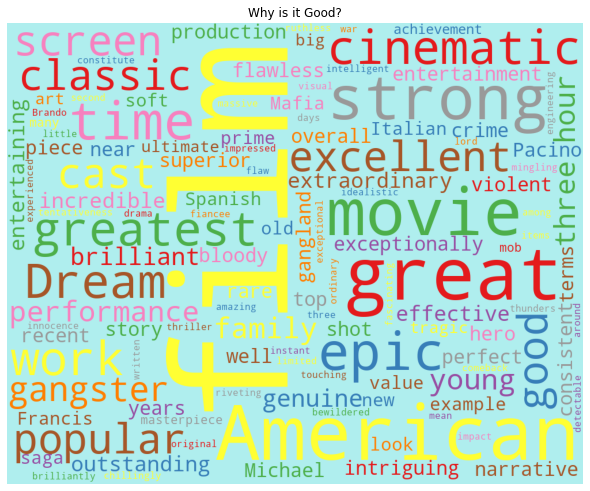

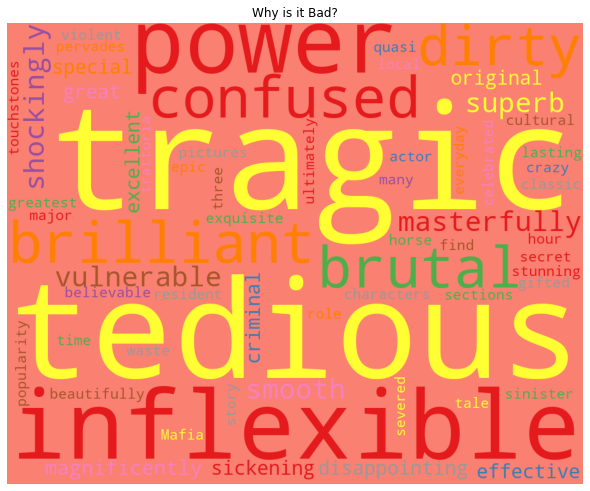

In [251]:
def wrd_cloud_pos_neg(show_url = False, max_wrds = 100):
  from tqdm.notebook import tqdm
  from wordcloud import WordCloud, STOPWORDS
  import matplotlib.pyplot as plt

  key_words = extract_wrds(reviews, clf, k = 50)
  pos_keys, neg_keys, preds = combine_wrd_np(reviews, key_words)
  pos_stuff = [p for p in pos_keys if len(p) >= 6]
  neg_stuff = [n for n in neg_keys if len(n) >= 6]
  sntmt_words = {"pos": pos_stuff, "neg": neg_stuff}

  # clr template
  avail_clrs = ["paleturquoise", "plum", "lightgreen", "salmon", "cornflowerblue", "navajowhite"]
  clrs = np.random.choice(avail_clrs, 2, replace = False)

  titles = ["Why is it Good?", "Why is it Bad?"]
  print("Overall Projected Rating")
  print(f"Rotten Tomato: {sum(labels)/len(labels)}")
  print(f"Bert: {sum(preds)/len(preds)}")

  for i, (label, key_words) in enumerate(sntmt_words.items()):
    
    clr = clrs[i]
    title = titles[i]
    # wrdcld generation
    wrds_4_cld = " ".join(key_words)
    wordcloud = WordCloud(width = 1000, height = 800, random_state=1999, 
                          background_color= clr, colormap='Set1', max_words = 120,
                          collocations=True, stopwords = STOPWORDS.union(stop_words)).generate(wrds_4_cld)


    # plot WordCloud                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    #plt.title(f"{label}-label keywords")
    plt.title(title)
    plt.show()

#### add pos tag as feature to clf

In [137]:
#nltk.pos_tag(nltk.word_tokenize(test_txt[0]))
all_pos = []
for txt in test_txt:
  all_pos += [t for _, t in nltk.pos_tag(nltk.word_tokenize(txt))]
len(all_pos)

18416

In [136]:
train_embeds.shape

(728, 768)

In [ ]:
nltk.download(["vader_lexicon"])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from textblob import TextBlob

def prepare_embed_and_label(corpus, first_k = None, report = False):
  """Prepare embedding and labels to be used for word sentiment classfication to 
  determine which dims of bert embed are useful here and .
        Parameters
        ----------
        corpus : {list of sentences} of length (n_samples)
            The input document that will be processed to extract useful embeddings.
        first_k : The number of sentences to process in corpus. Default: All. 
        report : whether to output a list of chosen words that are used to create the training
        embeddings. 

        Returns
        -------
        word_embed: the training embedding to be used. 
        labels: either -1 or 1, class label for each sentiment word.
        weights: a weight based on sentiment polarity by textblob and Vader
        """
  word_embed = None
  translate = {1: "pos", -1: "neg"}
  labels = []
  weights = []
  all_c_words = []
  agg_count_v = 0
  agg_count_t = 0
  mixed_polarity_words = set()

  if first_k is not None:
    limit = first_k
  else:
    limit = len(corpus)
  
  c_words = []
  for i,sent in enumerate(corpus[:limit]):
    

    for word in sent.split():
      if word in stop_words or word in puncs:
          continue

      ### Decide text polarity ###
      txt_blb_Sent = TextBlob(word).sentiment
      #print("lbl: ", txt_blb_Sent)
      txt_blb_Sent = txt_blb_Sent[0] * 0.7 + 0.3 * txt_blb_Sent[0] * txt_blb_Sent[1] #positivity * subjectivity
      
      vader_Sent = sia.polarity_scores(word)
      #print("vader: ", vader_Sent)
      vader_Pos = 1 if vader_Sent["pos"] > vader_Sent["neg"] else -1
      vader_Sent = vader_Sent["compound"] * 0. + \
                    vader_Pos * vader_Sent[translate[vader_Pos]] * 0.3
      ###
      if abs(txt_blb_Sent) > abs(vader_Sent):
        agg_count_t += 1 
      else:
        agg_count_v += 1
      ###

      #print("v_Sent", vader_Sent)
      ############################

      ### Label Creation ###
      if txt_blb_Sent * vader_Sent < 0:
        #print(f"Check inconsistent agreement for the word {word} in Sentence {i}")
        mixed_polarity_words.add(word)
        # Trust the more assertive one for now
        if abs(txt_blb_Sent) > abs(vader_Sent):
          vader_Sent *= -1 
        else:
          txt_blb_Sent *= -1
      
      if txt_blb_Sent > 0.3 or vader_Sent > 0.3:
        labels.append(1)
      elif txt_blb_Sent < -0.3 or vader_Sent < -0.3:
        labels.append(-1)
      else:
        continue 
      
      weights.append(abs((txt_blb_Sent + vader_Sent) * 0.5)) #only magnitude matters
      ############################

      idx = get_word_idx(sent, word)
      word_embedding = get_word_vector(sent, idx, tokenizer, model, layers).cpu().numpy()
      if word_embed is not None:
        word_embed = np.vstack([word_embed, word_embedding])
        c_words.append(word)
      else:
        word_embed = word_embedding
        c_words.append(word)
      
      #all_pos = []
      
    #all_c_words.append(c_words)
  
  print(f"Vader > Txtblb {agg_count_v}; Txtblb > Vader {agg_count_t}")
  print(f"All mixed polarity words {mixed_polarity_words}")
  if report:
    return word_embed, labels, weights, c_words
    #return word_embed, labels, weights, list(all_c_words)
  
  return word_embed, labels, weights

  

In [ ]:
for sentence in test_txt:
  tags = [t for _, t in nltk.pos_tag(nltk.word_tokenize(sentence))]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,\
                                 max_depth=2, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

### 50K movie review

In [1]:
import pandas as pd
imdb = pd.read_csv("IMDB Dataset.csv")

FileNotFoundError: ignored

In [ ]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
display(HTML(imdb.head(2).to_html()))

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


In [ ]:
display(HTML(imdb.tail(2).to_html()))

,review,sentiment
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that creaks and groans trying to put across its central theme of the Wild West being tamed and kicked aside by the steady march of time. It would like to be in the tradition of ""Butch Cassidy and the Sundance Kid"", but lacks that film's poignancy and charm. Andrew McLaglen's direction is limp, and the final 30 minutes or so are a real botch, with some incomprehensible strategy on the part of heroes Charlton Heston and Chris Mitchum. (Someone give me a holler if you can explain to me why they set that hillside on fire.) There was something callous about the whole treatment of the rape scene, and the woman's reaction afterwards certainly did not ring true. Coburn is plenty nasty as the half breed escaped convict out for revenge, but all of his fellow escapees are underdeveloped (they're like bowling pins to be knocked down one by one as the story lurches forward). Michael Parks gives one of his typically shifty, lethargic, mumbling performances, but in this case it was appropriate as his modern style sheriff symbolizes the complacency that technological progress can bring about.",negative
49999,"No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good as some of the best episodes. Unfortunately, this movie had a muddled, implausible plot that just left me cringing - this is by far the worst of the nine (so far) movies. Even the chance to watch the well known characters interact in another movie can't save this movie - including the goofy scenes with Kirk, Spock and McCoy at Yosemite.<br /><br />I would say this movie is not worth a rental, and hardly worth watching, however for the True Fan who needs to see all the movies, renting this movie is about the only way you'll see it - even the cable channels avoid this movie.",negative


#### Simple Preprocessing (since bert handles most)

In [3]:
imdb.review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [4]:
import re

In [5]:
pattern = re.compile(r'\<\w+\s*\/\>')
pattern.findall(imdb.review[1])

['<br />', '<br />', '<br />', '<br />', '<br />', '<br />']

In [6]:
re.sub(pattern, r'', imdb.review[1])

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [ ]:
imdb.sentiment

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [7]:
imdb.review = imdb.review.replace(pattern, '',regex=True)
imdb.sentiment = imdb.sentiment.apply(lambda x: 1 if x=='positive' else 0)

#### 4) Bert-summarizer (use for external large dataset)

In [ ]:
# from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

# sum_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
# sum_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

loading configuration file https://huggingface.co/facebook/bart-large-cnn/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/199ab6c0f28e763098fd3ea09fd68a0928bb297d0f76b9f3375e8a1d652748f9.930264180d256e6fe8e4ba6a728dd80e969493c23d4caa0a6f943614c52d34ab
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_generated": true,
  "forced_bos_token_id": 0,
  "

In [ ]:
imdb.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [ ]:
from transformers import pipeline
summarizer = pipeline("summarization")

https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgb36hgns


storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
creating metadata file for /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout":

loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
creating metadata file for /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
loading weights file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844


All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-cnn-12-6.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartForConditionalGeneration for predictions without further training.
https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpbjo60rcp


storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
creating metadata file for /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8


loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
creating metadata file for /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05


https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpaeo692g4


storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b


loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer_config.json from

In [ ]:
summarizer("An apple a day, keeps the doctor away", min_length=5, max_length=10)

[{'summary_text': ' An apple a day, keeps the'}]

In [ ]:
summarizer(imdb.review[1], min_length=5, max_length=20)

[{'summary_text': ' The filming technique is very unassuming- very old-time-BBC fashion . The'}]

In [ ]:
ARTICLE_TO_SUMMARIZE = imdb.review[1]
inputs = sum_tokenizer([ARTICLE_TO_SUMMARIZE], truncation = True, max_length=1024, return_tensors='pt')
a
# Generate Summary
summary_ids = sum_model.generate(inputs['input_ids'], num_beams=4, max_length=5, early_stopping=True)
print([sum_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

['A wonderful']


In [ ]:
from transformers import BartTokenizer, BartModel
check_pt = 'facebook/bart-large-cnn'
sum_tokenizer = BartTokenizer.from_pretrained(check_pt)
sum_model = BartModel.from_pretrained(check_pt)

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")

In [ ]:
# ARTICLE_TO_SUMMARIZE = "My friends are cool but they eat too many carbs."
# inputs = sum_tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

In [ ]:
sum_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
sum_model = BartModel.from_pretrained(check_pt)
trainer = Trainer(model=sum_model, args=sum_training_args, 
                  train_dataset=train_dataset, eval_dataset=val_dataset)
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Step,Training Loss
10,0.688300
20,0.686700
30,0.691800
40,0.686700
50,0.685000
60,0.681600
70,0.675000
80,0.664300
90,0.646500
100,0.617600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=940, training_loss=0.1693283485560777, metrics={'train_runtime': 39.1673, 'train_samples_per_second': 382.973, 'train_steps_per_second': 24.0, 'total_flos': 355531103100000.0, 'train_loss': 0.1693283485560777, 'epoch': 10.0})

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# validation eval 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 64


{'eval_accuracy': 0.856,
 'eval_loss': 0.9057413339614868,
 'eval_runtime': 0.3192,
 'eval_samples_per_second': 1566.337,
 'eval_steps_per_second': 25.061}

#### Without summarization

In [ ]:
imdb_encodings = tokenizer(imdb.review.tolist()[:500], truncation=True, padding=True)
imdb_dataset = SentimentDataset(imdb_encodings, imdb.sentiment.values)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    #print(idx)
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [ ]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

#imdb_dataset = SimpleDataset(imdb_encodings)
tr_encodings = tokenizer(imdb.review.tolist()[:2000], truncation=True, padding=True)
train_dataset = SimpleDataset(tr_encodings)
vl_encodings = tokenizer(imdb.review.tolist()[2000:3000], truncation=True, padding=True)
val_dataset = SimpleDataset(vl_encodings)
ts_encodings = tokenizer(imdb.review.tolist()[3000:4000], truncation=True, padding=True)
test_dataset = SimpleDataset(ts_encodings)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
# trainer = Trainer(model=model, args=training_args, 
#                   train_dataset=train_dataset, eval_dataset=val_dataset)
# trainer.train()

In [ ]:
imdb_pred = trainer.predict(imdb_dataset)

In [ ]:
imdb_sent_prds = np.argmax(imdb_pred.predictions[0], axis = 1)

In [ ]:
np.sum(imdb_sent_prds == imdb.sentiment[:500]) / 500

0.868

In [ ]:
imdb.review[:1]

0    One of the other reviewers has mentioned that ...
Name: review, dtype: object

In [ ]:
extract_wrds(imdb.review.tolist()[:5], clf, k = 5)

Vader > Txtblb 493; Txtblb > Vader 73
All mixed polarity words set()
Model Accuracy: {acc}


{'neg': array(['uncomfortable', 'meaningless', 'sincere', 'many', 'disappointed'],
       dtype='<U13'),
 'pos': array(['light-hearted', 'interesting', 'Stylishly,', 'impressed', '"Love'],
       dtype='<U13')}

## 50K + IMDB scraping (w/ review tag generation)

### Func init

In [2]:
!pip install transformers
!pip install transformers_interpret
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
try:
   from datasets import load_metric
except:
  !pip install datasets
  from datasets import load_metric
from transformers import TrainingArguments, Trainer
import numpy as np
import pandas as pd
import torch
import transformers as tfm 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import string 
import nltk 
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(STOPWORDS)
puncs = string.punctuation 
from transformers_interpret import SequenceClassificationExplainer
nltk.download(["vader_lexicon"])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from textblob import TextBlob
from tqdm.notebook import tqdm

     |████████████████████████████████| 2.5MB 3.8MB/s 
     |████████████████████████████████| 3.3MB 17.2MB/s 
     |████████████████████████████████| 901kB 35.6MB/s 
     |████████████████████████████████| 1.4MB 4.8MB/s 
  Created wheel for transformers-interpret: filename=transformers_interpret-0.5.2-cp37-none-any.whl size=23516 sha256=0b71f04d5c51fa8f6a47a0c4ee4c7dff6177d36526b41ccd0e93dd55fdfbb69e
  Stored in directory: /root/.cache/pip/wheels/b7/01/6c/eccaa6012064b234c01cf5b883c95c69f756cabadb1451a599
Successfully built transformers-interpret
     |████████████████████████████████| 266kB 3.9MB/s 
     |████████████████████████████████| 245kB 10.6MB/s 
     |████████████████████████████████| 122kB 11.1MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [5]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 
sum(df[1][2000:] == 1) #close to 2.5k for gd shuffle

2588

In [6]:
train_txt = df[0:4000][0].tolist()
train_txt, val_txt, train_labels, val_labels = train_test_split(train_txt, df[0:4000][1].tolist())

In [7]:
test_txt = df[4000:][0].tolist()
test_sentiment = df[4000:][1].tolist()
train_encodings = tokenizer(train_txt, truncation=True, padding=True)
val_encodings = tokenizer(val_txt, truncation=True, padding=True)
test_encodings = tokenizer(test_txt, truncation=True, padding=True)

In [8]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    #print(idx)
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [9]:
#training_args = TrainingArguments("test_trainer")

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [10]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
trainer = Trainer(model=model, args=training_args, 
                  train_dataset=train_dataset, eval_dataset=val_dataset)
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

Step,Training Loss
10,0.702700
20,0.701000
30,0.696900
40,0.694200
50,0.685300
60,0.694500
70,0.684000
80,0.672000
90,0.635800
100,0.571400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1880, training_loss=0.1223746227418776, metrics={'train_runtime': 143.2363, 'train_samples_per_second': 209.444, 'train_steps_per_second': 13.125, 'total_flos': 807477420600000.0, 'train_loss': 0.1223746227418776, 'epoch': 10.0})

In [11]:
def get_word_idx(sent: str, word: str):
     return sent.split(" ").index(word)

def get_hidden_states(encoded, word_indx_in_token, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last 3 by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    with torch.no_grad():
        input_ids = encoded['input_ids'].cuda() #using GPU
        attention_mask = encoded['attention_mask'].cuda() #using GPU
        output = model(input_ids, attention_mask = attention_mask)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[word_indx_in_token]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest, mask all other ones
    word_indx_in_token = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, word_indx_in_token, model, layers)


In [12]:
layers = [-3, -2, -1]

In [13]:

def prepare_embed_and_label(corpus, first_k = None, report = True):
  """Prepare embedding and labels to be used for word sentiment classfication to 
  determine which dims of bert embed are useful here and .
        Parameters
        ----------
        corpus : {list of sentences} of length (n_samples)
            The input document that will be processed to extract useful embeddings.
        first_k : The number of sentences to process in corpus. Default: All. 
        report : whether to output a list of chosen words that are used to create the training
        embeddings. 

        Returns
        -------
        word_embed: the training embedding to be used. 
        labels: either -1 or 1, class label for each sentiment word.
        weights: a weight based on sentiment polarity by textblob and Vader
        """
  word_embed = None
  translate = {1: "pos", -1: "neg"}
  labels = []
  weights = []
  all_c_words = []
  agg_count_v = 0
  agg_count_t = 0
  mixed_polarity_words = set()

  if first_k is not None:
    limit = first_k
  else:
    limit = len(corpus)
  
  c_words = []
  for i,sent in enumerate(corpus[:limit]):
    

    for word in sent.split():
      if word in stop_words or word in puncs:
          continue

      ### Decide text polarity ###
      txt_blb_Sent = TextBlob(word).sentiment
      #print("lbl: ", txt_blb_Sent)
      txt_blb_Sent = txt_blb_Sent[0] * 0.7 + 0.3 * txt_blb_Sent[0] * txt_blb_Sent[1] #positivity * subjectivity
      
      vader_Sent = sia.polarity_scores(word)
      #print("vader: ", vader_Sent)
      vader_Pos = 1 if vader_Sent["pos"] > vader_Sent["neg"] else -1
      vader_Sent = vader_Sent["compound"] * 0. + \
                    vader_Pos * vader_Sent[translate[vader_Pos]] * 0.3
      ###
      if abs(txt_blb_Sent) > abs(vader_Sent):
        agg_count_t += 1 
      else:
        agg_count_v += 1
      ###

      #print("v_Sent", vader_Sent)
      ############################

      ### Label Creation ###
      if txt_blb_Sent * vader_Sent < 0:
        #print(f"Check inconsistent agreement for the word {word} in Sentence {i}")
        mixed_polarity_words.add(word)
        # Trust the more assertive one for now
        if abs(txt_blb_Sent) > abs(vader_Sent):
          vader_Sent *= -1 
        else:
          txt_blb_Sent *= -1
      
      if txt_blb_Sent > 0.3 or vader_Sent > 0.3:
        labels.append(1)
      elif txt_blb_Sent < -0.3 or vader_Sent < -0.3:
        labels.append(-1)
      else:
        continue 
      
      weights.append(abs((txt_blb_Sent + vader_Sent) * 0.5)) #only magnitude matters
      ############################

      idx = get_word_idx(sent, word)
      word_embedding = get_word_vector(sent, idx, tokenizer, model, layers).cpu().numpy()
      if word_embed is not None:
        word_embed = np.vstack([word_embed, word_embedding])
        c_words.append(word)
      else:
        word_embed = word_embedding
        c_words.append(word)
      
      
    #all_c_words.append(c_words)
  
  print(f"Vader > Txtblb {agg_count_v}; Txtblb > Vader {agg_count_t}")
  print(f"All mixed polarity words {mixed_polarity_words}")
  if report:
    return word_embed, labels, weights, c_words
    #return word_embed, labels, weights, list(all_c_words)
  
  return word_embed, labels, weights

  

In [28]:
word_embeds, labels, weights, c_words = prepare_embed_and_label(df[0].tolist(), report = True)
train_embeds, val_embeds, train_pack, val_pack = train_test_split(word_embeds, list(zip(labels, weights, c_words)), train_size = 0.8)
#test_embeds, test_labels, test_weights, test_words = prepare_embed_and_label(test_txt, report = True)

Vader > Txtblb 60097; Txtblb > Vader 10799
All mixed polarity words {'whimsical', 'silly', 'delicate', 'laughable', 'carefully', 'controversial', 'delicately', 'laughably', 'curious', 'sentimental', 'bizarre', 'excuse', 'passionately', 'passionate', 'infatuated', 'casual', 'unbelievable', 'crushing', 'overwhelmingly', 'careful', 'grey', 'ironic', 'startling'}


In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weights = scaler.fit_transform(X = np.array(weights)[:, None]).ravel() #prevent over-shrinking weights as all are < 1
test_weights = scaler.transform(X = np.array(test_weights)[:, None]).ravel()

train_labels = []
train_weights = []
train_words = []
for lbl, wt, wrd in train_pack:
  train_labels.append(lbl)
  train_weights.append(wt)
  train_words.append(wrd)

val_labels = []
val_weights = []
val_words = []
for lbl, wt, wrd in val_pack:
  val_labels.append(lbl)
  val_weights.append(wt)
  val_words.append(wrd)

# train_weights = [w for _, w, _ in train_labels]
# test_weights = [w for _, w, _ in test_labels]
# train_labels = [l for l, _, _ in train_labels]
# test_labels = [l for l, _, _ in test_labels]


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,\
                                 subsample = 0.4, 
                                 min_samples_split = 50, min_samples_leaf = 20,
                                 max_depth=2, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

In [31]:
print(sum(clf.predict(train_embeds) == np.array(train_labels)) / len(train_labels))
sum(clf.predict(test_embeds) == np.array(test_labels)) / len(test_labels)

0.9683372183372183


0.9272334293948127

In [17]:
sum(clf.predict(train_embeds) == np.array(train_labels)) / len(train_labels)

0.9966118102613747

In [18]:
sum(clf.predict(test_embeds) == np.array(test_labels)) / len(test_labels)

0.8969740634005764

In [92]:
from sklearn.model_selection import GridSearchCV
parameters = {'subsample':[1, 0.2, 0.4], 'min_samples_split':[10, 20, 50], 'min_samples_leaf':[5, 10, 30]}
opt_clf = GridSearchCV(clf, parameters)
opt_clf.fit(X=train_embeds, y=train_labels, sample_weight=train_weights)
print("best param: ", opt_clf.best_params_)
print("best score: ", opt_clf.best_score_)

best param:  {'min_samples_leaf': 5, 'min_samples_split': 50, 'subsample': 0.4}
best score:  0.8862877929512791


In [99]:
for n in np.linspace(200, 1000, 9):
  n = int(n)
  
  clf = GradientBoostingClassifier(n_estimators= n, learning_rate=0.05,\
                                 max_depth=2, subsample = 0.4, 
                                 min_samples_split = 50, 
                                 min_samples_leaf = 5, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

  print(n)
  print(sum(np.array(train_labels) == clf.predict(train_embeds)) / len(train_labels)) 
  print(sum(np.array(val_labels) == clf.predict(val_embeds)) / len(val_labels)) 
  print("========================================")

200
0.9673011224987799
0.8799414348462665
300
0.9858467545143973
0.8872620790629575
400
0.9926793557833089
0.890190336749634
500
0.997559785261103
0.8887262079062958
600
1.0
0.8857979502196194
700
1.0
0.8843338213762811
800
1.0
0.8814055636896047
900
1.0
0.8857979502196194
1000
1.0
0.890190336749634


In [94]:
print(sum(np.array(train_labels) == opt_clf.best_estimator_.predict(train_embeds)) / len(train_labels)) 

0.9673011224987799


In [93]:
print(sum(np.array(val_labels) == opt_clf.best_estimator_.predict(val_embeds)) / len(val_labels)) 

0.8799414348462665


In [91]:
print(sum(np.array(train_labels) == clf.predict(train_embeds)) / len(train_labels))
print(sum(np.array(train_labels) != clf.predict(train_embeds))) #expect 12 wrong preds
print("Word | predicted label based on embedding")
list(zip(np.array(train_words)[np.array(train_labels) != clf.predict(train_embeds)], \
np.array(clf.predict(train_embeds))[np.array(train_labels) != clf.predict(train_embeds)]))


0.9741337237676916
53
Word | predicted label based on embedding


[('casual', 1),
 ('endearing', -1),
 ('game', 1),
 ('unsettling', 1),
 ('cheap', -1),
 ('dramatic', 1),
 ('light', -1),
 ('blatantly', 1),
 ('rich', -1),
 ('mighty', -1),
 ('sloppily', 1),
 ('gay', -1),
 ('shrieky', 1),
 ('goofy', -1),
 ('smoothly', -1),
 ('startling', 1),
 ('dramatic', 1),
 ('filled', -1),
 ('offbeat', 1),
 ('tough', 1),
 ('unforgettable', -1),
 ('bored', 1),
 ('grief', 1),
 ('many', -1),
 ('light', -1),
 ('original', -1),
 ('tough', 1),
 ('outrageous', 1),
 ('insecure', 1),
 ('dramatic', 1),
 ('engrossing', -1),
 ('cold', 1),
 ('insanely', 1),
 ('astonishingly', -1),
 ('skittish', -1),
 ('cheap', -1),
 ('unlikely', 1),
 ('fairly', -1),
 ('tough', 1),
 ('startling', 1),
 ('secret', 1),
 ('dramatic', 1),
 ('whimsical', 1),
 ('thin', 1),
 ('dramatic', 1),
 ('mere', 1),
 ('raunchy', 1),
 ('mere', 1),
 ('secret', 1),
 ('weirdly', 1),
 ('cheap', -1),
 ('gory', 1),
 ('cold', 1)]

In [74]:
print(sum(np.array(val_labels) == clf.predict(val_embeds)) / len(val_labels))
print(sum(np.array(val_labels) != clf.predict(val_embeds))) #expect 12 wrong preds
print("Word | predicted label based on embedding")
list(zip(np.array(val_words)[np.array(val_labels) != clf.predict(val_embeds)], \
np.array(clf.predict(val_embeds))[np.array(val_labels) != clf.predict(val_embeds)]))

0.8726207906295754
87
Word | predicted label based on embedding


[('kind', -1),
 ('great', -1),
 ('desperately', 1),
 ('vaguely', 1),
 ('sinister', 1),
 ('chilling', 1),
 ('happily', -1),
 ('accessible', -1),
 ('distasteful', 1),
 ('rank', 1),
 ('becoming', -1),
 ('flashy', 1),
 ('cheap', -1),
 ('silly', 1),
 ('creepy', 1),
 ('exceptional', -1),
 ('brutal', 1),
 ('outrageous', 1),
 ('goofy', -1),
 ('complicated', 1),
 ('spirited', -1),
 ('irritating', 1),
 ('secret', 1),
 ('forgettable', 1),
 ('cheery', -1),
 ('merely', 1),
 ('behind', 1),
 ('many', -1),
 ('fairly', -1),
 ('devastatingly', 1),
 ('tough', 1),
 ('vulnerable', 1),
 ('full', -1),
 ('sloppy', 1),
 ('unlikely', 1),
 ('sorry', 1),
 ('fairly', -1),
 ('contrived', 1),
 ('endearing', -1),
 ('original', -1),
 ('offbeat', 1),
 ('dramatic', 1),
 ('confused', 1),
 ('easily', -1),
 ('tragic', 1),
 ('good', -1),
 ('painfully', 1),
 ('top', -1),
 ('dramatic', 1),
 ('outrageous', 1),
 ('game', 1),
 ('forgettable', 1),
 ('latest', -1),
 ('unsettling', 1),
 ('cold', 1),
 ('appropriately', -1),
 ('impos

In [67]:
len(val_labels)

683

### Showcase: Scraping for reviews

In [14]:
import requests
import numpy as np
import pandas as pd
import lxml.html as lh
from bs4 import BeautifulSoup
import re

In [15]:
try:
    from googlesearch import search
except ImportError: 
    print("No module named 'google' found")

def extract_movie_reviews(title = None, title_type = None, All = True, print_url = False):

  #sites = ["Rotten Tomatoes", "IMDB", "Metacritic"]
  #assert site in sites, f"Site needs to be one of these: {sites}" #only RT now

  # to search
  site = "Rotten Tomatoes"
  grps = ['All_critics'] if All else ['top_critics', 'verified_audience']
  if title is None:
    title = input("Enter the Movie/Show you want to search for: ")
    title = title.lower()
  if title_type is None:
    title_type = input("Enter for type to search (tv/movie): ")
    title_type = title_type.lower()
  allowed_types = ["tv", "movie"]
  assert title_type in allowed_types, f"title_type must be {allowed_types}"

  if title_type == "tv":
    szn = input("Enter season number (e.g. 01 or None): ")
    if szn.lower() == "none":
      szn = ''
    else:
      szn = '/s' + szn

  else:
    szn = ''

  reviews = []
  labels = []
  r_count = 0 
  l_count = 0 

  query = site + title

  for grp in grps:
    if grp == 'All_critics':
      append = szn + '/reviews?type='
    else: 
      append = szn + '/reviews?type={}'.format(grp)


    url = next(search(query, num=10, stop=5, pause= 1)) + append
    pattern = re.compile(r'(www\..+\.com\/)([^\/]+)(\/.+)')
    
    # mandatory check/correction for url
    my_sub = 'm' if title_type == "movie" else 'tv'
    url = pattern.sub(f'\\1{my_sub}\\3', url)
    #################################
    #get page/html contents
    r = requests.get(url) 
    soup = BeautifulSoup(r.content, 'html.parser')

    ## Iterate over pages
    page_url = '&sort=&page={}'
    result = soup.find_all("span", class_ = "pageInfo")
    if not result:
      continue #jump to next grp as curr does not exist for this movie/show

    num_page = int(result[0].string.split()[-1])
    page = 1
    while page <= num_page:
      result = soup.find_all("div", class_="the_review")
      if not result:
        result = soup.find_all("div", class_="critic__review-quote")
        if not result:
          break

      for sent in result:
        reviews.append(' '.join(str(sent.string).split()))
        r_count += 1


      # extract review sentiment
      for sent in soup.find_all("div", class_="review_icon"):
        labels.append(1 if sent.attrs["class"][-1] == "fresh" else 0)
        l_count += 1

      if r_count != l_count:
        raise ValueError(f"Size mismatch (review/label) {r_count} != {l_count}, missing review or label")
      
      if print_url:
        if page == 1:
          print(url)
        elif page <= num_page:
          print(new_url)

      page += 1
      new_url = url + page_url.format(page)
      r = requests.get(new_url) 
      soup = BeautifulSoup(r.content, 'html.parser')
      
  if labels:
    print(f"Projected score: {sum(labels)/len(labels) * 100} ")
  else:
    print(f"Extraction failed: check spelling, or data format not supported on this page. Title searched was {title}")
  return reviews, labels


In [23]:
reviews, labels = extract_movie_reviews(All= True, print_url = True)

Enter the Movie/Show you want to search for: altered carbon
Enter for type to search (tv/movie): tv
Enter season number (e.g. 01 or None): 01
https://www.rottentomatoes.com/tv/altered_carbon/s01/reviews?type=
https://www.rottentomatoes.com/tv/altered_carbon/s01/reviews?type=&sort=&page=2
https://www.rottentomatoes.com/tv/altered_carbon/s01/reviews?type=&sort=&page=3
https://www.rottentomatoes.com/tv/altered_carbon/s01/reviews?type=&sort=&page=4
https://www.rottentomatoes.com/tv/altered_carbon/s01/reviews?type=&sort=&page=5
Projected score: 68.75 


In [24]:
reviews, labels = extract_movie_reviews(All= True, print_url = True)

Enter the Movie/Show you want to search for: the god father
Enter for type to search (tv/movie): movie
https://www.rottentomatoes.com/m/godfather/reviews?type=
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=2
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=3
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=4
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=5
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=6
https://www.rottentomatoes.com/m/godfather/reviews?type=&sort=&page=7
Projected score: 96.96969696969697 


In [27]:
print(len(reviews), len(labels))
print(list(zip(reviews[:3], labels[:3])))
list(zip(reviews[-3:], labels[-3:]))

132 132
[('The Godfather shows that there is still life in the massive production engineering which made Hollywood studios the wonder of the entertainment world in their great days.', 1), ('The intimate camerawork, highlighted by closeups and staging actors as if in a void, creates a sinister edge to every scene.', 1), ("The supporting cast is a marvel, including Diane Keaton as Pacino's bewildered fiancee, Robert Duvall as Brando's second-in-command, James Caan as Pacino's headstrong brother, [and] Al Martino in a role patterned after Frank Sinatra.", 1)]


[('Corleone, the soft-spoken crimelord, is masterfully played by Brando in one of the most imitated performances of all time.',
  1),
 ("Over The Godfather's three-hour running time, the story of Michael's transformation from a 'civilian' in a mob family into its hard-nosed general never flags.",
  1),
 ('As scary as it is intelligent, as funny as it is touching, The Godfather is a prime example of the way cinema should be: excellent telling of complete stories.',
  1)]

In [31]:
reviews, labels = extract_movie_reviews(All = False, print_url = True)

Enter the Movie/Show you want to search for: loki
Enter for type to search (tv/movie): tv
Enter season number (e.g. 01 or None): 01
https://www.rottentomatoes.com/tv/loki/s01/reviews?type=top_critics
https://www.rottentomatoes.com/tv/loki/s01/reviews?type=top_critics&sort=&page=2
Projected score: 93.33333333333333 


In [32]:
reviews, labels = extract_movie_reviews(All = True, print_url = True) #e.g. friends x work as html specs differ for older shows

Enter the Movie/Show you want to search for: black widow
Enter for type to search (tv/movie): movie
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=2
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=3
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=4
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=5
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=6
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=7
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=8
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=9
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=10
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&sort=&page=11
https://www.rottentomatoes.com/m/black_widow_2021/reviews?type=&

#### Additional list of movies for training

In [10]:
movies = """1.CITIZEN KANE (1941)
2.CASABLANCA (1942)
3.GODFATHER, THE (1972)
4.GONE WITH THE WIND (1939)
5.LAWRENCE OF ARABIA (1962)
6.WIZARD OF OZ, THE (1939)
7.GRADUATE, THE (1967)
8.ON THE WATERFRONT (1954)
9.SCHINDLER'S LIST (1993)
10.SINGIN' IN THE RAIN (1952)
11.IT'S A WONDERFUL LIFE (1946)
12.SUNSET BOULEVARD (1950)
13.BRIDGE ON THE RIVER KWAI, THE (1957)
14.SOME LIKE IT HOT (1959)
15.STAR WARS (1977)
16.ALL ABOUT EVE (1950)
17.AFRICAN QUEEN, THE (1951)
18.PSYCHO (1960)
19.CHINATOWN (1974)
20.ONE FLEW OVER THE CUCKOO'S NEST (1975)
21.GRAPES OF WRATH, THE (1940)
22.2001: A SPACE ODYSSEY (1968)
23.MALTESE FALCON, THE (1941)
24.RAGING BULL (1980)
25.E.T. THE EXTRA-TERRESTRIAL (1982)
26.DR. STRANGELOVE (1964)
27.BONNIE & CLYDE (1967)
28.APOCALYPSE NOW (1979)
29.MR. SMITH GOES TO WASHINGTON (1939)
30.TREASURE OF THE SIERRA MADRE (1948)
31.ANNIE HALL (1977)
32.GODFATHER PART II, THE (1974)
33.HIGH NOON (1952)
34.TO KILL A MOCKINGBIRD (1962)
35.IT HAPPENED ONE NIGHT (1934)
36.MIDNIGHT COWBOY (1969)
37.BEST YEARS OF OUR LIVES, THE (1946)
38.DOUBLE INDEMNITY (1944)
39.DOCTOR ZHIVAGO (1965)
40.NORTH BY NORTHWEST (1959)
41.WEST SIDE STORY (1961)
42.REAR WINDOW (1954)
43.KING KONG (1933)
44.BIRTH OF A NATION, THE (1915)
45.STREETCAR NAMED DESIRE, A (1951)
46.CLOCKWORK ORANGE, A (1971)
47.TAXI DRIVER (1976)
48.JAWS (1975)
49.SNOW WHITE & THE SEVEN DWARFS (1937)
50.BUTCH CASSIDY & THE SUNDANCE KID (1969)
51.PHILADELPHIA STORY, THE(1940)
52.FROM HERE TO ETERNITY (1953)
53.AMADEUS (1984)
54.ALL QUIET ON THE WESTERN FRONT (1930)
55.SOUND OF MUSIC, THE (1965)
56.M*A*S*H(1970)
57.THIRD MAN, THE (1949)
58.FANTASIA (1940)
59.REBEL WITHOUT A CAUSE (1955)
60.RAIDERS OF THE LOST ARK (1981)
61.VERTIGO (1958)
62.TOOTSIE (1982)
63.STAGECOACH (1939)
64.CLOSE ENCOUNTERS OF THE THIRD KIND (1977)
65.SILENCE OF THE LAMBS, THE (1991)
66.NETWORK (1976)
67.MANCHURIAN CANDIDATE, THE (1962)
68.AMERICAN IN PARIS, AN (1951)
69.SHANE (1953)
70.FRENCH CONNECTION, THE (1971)
71.FORREST GUMP (1994)
72.BEN-HUR (1959)
73.WUTHERING HEIGHTS (1939)
74.GOLD RUSH, THE (1925)
75.DANCES WITH WOLVES (1990)
76.CITY LIGHTS (1931)
77.AMERICAN GRAFFITI (1973)
78.ROCKY (1976)
79.DEER HUNTER, THE (1978)
80.WILD BUNCH, THE (1969)
81.MODERN TIMES (1936)
82.GIANT (1956)
83.PLATOON (1986)
84.FARGO (1996)
85.DUCK SOUP (1933)
86.MUTINY ON THE BOUNTY (1935)
87.FRANKENSTEIN (1931)
88.EASY RIDER (1969)
89.PATTON (1970)
90.JAZZ SINGER, THE (1927)
91.MY FAIR LADY (1964)
92.PLACE IN THE SUN, A(1951)
93.APARTMENT, THE (1960)
94.GOODFELLAS (1990)
95.PULP FICTION (1994)
96.SEARCHERS, THE (1956)
97.BRINGING UP BABY (1938)
98.UNFORGIVEN (1992)
99.GUESS WHO'S COMING TO DINNER (1967)
100. YANKEE DOODLE DANDY (1942)"""

pattern = re.compile(r'\d+\.(.+)\s(THE)*\(.+')
movies = pattern.sub(f'\\2\\1', movies)#.split('\n')
pattern = re.compile(r'(\w+)(,\s(THE))*')
movies = pattern.sub(f'\\3 \\1', movies).split('\n')
movies = [m[1:] if m[0] == ' ' else m for m in movies]

In [34]:
movies[:10]

['CITIZEN  KANE',
 'CASABLANCA',
 'THE GODFATHER',
 'GONE  WITH  THE  WIND',
 'LAWRENCE  OF  ARABIA',
 'WIZARD  OF THE OZ',
 'THE GRADUATE',
 'ON  THE  WATERFRONT',
 "SCHINDLER' S  LIST",
 "SINGIN'  IN  THE  RAIN"]

In [41]:
movies.index(mov)

84

In [45]:
all_reviews = []
all_labels = []
sep_reviews = []
sep_labels = []
for mov in movies:
  reviews, labels = extract_movie_reviews(mov, "movie")
  all_reviews += reviews
  all_labels += labels
  sep_reviews.append(reviews)
  sep_labels.append(labels)


In [24]:
len(all_reviews), len(all_labels)

(7762, 7762)

In [50]:
class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    #print(idx)
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [73]:
train_txt = df[0].tolist() + imdb.review.tolist()[:2000]
train_txt, test_txt, train_labels, test_labels = train_test_split(train_txt, df[1].tolist() + imdb.sentiment.tolist()[:2000])

train_encodings = tokenizer(train_txt, truncation=True, padding=True)
test_encodings = tokenizer(test_txt, truncation=True, padding=True)
train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
trainer = Trainer(model=model, args=training_args, 
                  train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,


Step,Training Loss
10,0.694100
20,0.702000
30,0.699200
40,0.688900
50,0.675700
60,0.683700
70,0.657400
80,0.637400
90,0.603400
100,0.533400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=940, training_loss=0.16074383132149803, metrics={'train_runtime': 238.8001, 'train_samples_per_second': 62.814, 'train_steps_per_second': 3.936, 'total_flos': 3085286860800000.0, 'train_loss': 0.16074383132149803, 'epoch': 10.0})

In [57]:
# reviews, labels = extract_movie_reviews(All = True, print_url = True) #e.g. friends x work as html specs differ for older shows

In [65]:
def custom_review_classify(review):
  class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

  if not isinstance(review, str):
    raise ValueError("Input review must be a str object!")
  
  review = [review]
  rv_encodings = tokenizer(review, truncation=True, padding=True)
  rv_dataset = SimpleDataset(rv_encodings)
  
  pred = trainer.predict(rv_dataset)
  pred = np.argmax(pred.predictions[0], axis = 1)
  return pred

In [ ]:
preds = custom_review_classify(reviews)
sum(preds == labels) / len(labels)

***** Running Prediction *****
  Num examples = 132
  Batch size = 64


0.8712121212121212

In [68]:
print(custom_review_classify("Black widow painted its own heart-gripping moments that fill us with both joy and sorrow, for the buried histories of humanized heros."))
print(custom_review_classify("A final place of backstory and closure for one of the most fan-favoriate superhero to commemorate an end of the previous era of Marval Cinematics"))
print(custom_review_classify("This movie filled me with tears of forlorn sorrow of the deceased hero who has just found, rescued yet lost her families."))
print(custom_review_classify("The tacky performances and filler dialogues only helps to distract the audiences away from the predictable plot"))

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


***** Running Prediction *****
  Num examples = 1
  Batch size = 64


[1]


***** Running Prediction *****
  Num examples = 1
  Batch size = 64


[1]


***** Running Prediction *****
  Num examples = 1
  Batch size = 64


[1]
[1]


In [82]:
#max(len(_) for _ in train_txt)
max(len(_) for _ in all_reviews)

255

In [1]:
word_embeds, labels, weights, c_words = prepare_embed_and_label(train_txt, report = True)
train_embeds, test_embeds, train_pack, test_pack = train_test_split(word_embeds, list(zip(labels, weights, c_words)))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weights = scaler.fit_transform(X = np.array(weights)[:, None]).ravel() #prevent over-shrinking weights as all are < 1

train_labels = []
train_weights = []
train_words = []
for lbl, wt, wrd in train_pack:
  train_labels.append(lbl)
  train_weights.append(wt)
  train_words.append(wrd)

test_labels = []
test_weights = []
test_words = []
for lbl, wt, wrd in test_pack:
  test_labels.append(lbl)
  test_weights.append(wt)
  test_words.append(wrd)

# train_weights = [w for _, w, _ in train_labels]
# test_weights = [w for _, w, _ in test_labels]
# train_labels = [l for l, _, _ in train_labels]
# test_labels = [l for l, _, _ in test_labels]

clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,\
                                 subsample = 0.4, 
                                 min_samples_split = 50, min_samples_leaf = 20,
                                 max_depth=2, random_state= 0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

In [127]:
mask = preds != labels
list(zip(np.array(reviews)[mask], preds[mask]))
# All positive cases predicted as negative
# cases not captured:
# 1. change of tone (e.g. bad -> gd);
# 2. use of negative adj for positive meaning (sickening masterpiece)
# 3. Vague language 
# 4. double negative
# 5. out of context reference (e.g. Citizen Kane)

[("The Godfather runs a full-bodied 175 minutes, but fear not, you'll be mesmerized for every one of those minutes.",
  0),
 ("The film version of Mario Puzo's The Godfather, is a sickening masterpiece. It's the gangster movie come of age. It's a magnificently constructed chronicle of the Mafia and its families.",
  0),
 ('To permit us a glimpse at The Mob, with all of its ethnic insularity, is like giving a chronic gambler a chance to wander above the false mirrors that overlook every casino.',
  0),
 ("It's hard to find a moment in the film that isn't great. The Godfather lives up to the term masterpiece.",
  0),
 ('A measured, deathly serious epic.', 0),
 ("Like Citizen Kane, The Godfather doesn't age.", 0),
 ('How do you write a review about the greatest movie ever made?', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('', 0),
 ('Aquel que no ha visto El Padrino no puede decir que ama al cine', 0),
 ('It engulfs us in the lives of a lot of despicable people, but 

### Generate movie tags

In [13]:
def extract_wrds(txt, clf, k = 5):
  '''
  Input: txt (a list of sentences)
  Output: Most important sentiment words in the given txt (pos and neg)
  '''
  word_embeds, labels, weights, c_words = prepare_embed_and_label(txt, report = True)
  pred = clf.predict(word_embeds) 
  acc = sum(pred == labels) / len(labels)
  print(f"Model Accuracy: {acc}")
  probs = clf.predict_proba(word_embeds)
  c_words = np.array(c_words)
  pos_wrds = c_words[np.argsort(probs[:, 0])][10:k+10] #offset to escape some obvious positive terms
  neg_wrds = c_words[np.argsort(probs[:, 1])][:k]
  return {"pos": pos_wrds.tolist(), "neg": neg_wrds.tolist()}


In [256]:
def wrd_cloud_pos_neg(show_url = False, max_wrds = 100):
  from tqdm.notebook import tqdm
  from wordcloud import WordCloud, STOPWORDS
  import matplotlib.pyplot as plt
  # prompt for movie/show selection
  reviews, labels = extract_movie_reviews(All= True, print_url = show_url)
  print("Reviews extracted from Rotten Tomatoes!")

  print("Processing for key words...")
  # key wrd extraction
  key_words = extract_wrds(reviews, clf, k = 50)
  print("Obtaining additional short summaries...")
  pos_keys, neg_keys, preds = combine_wrd_np(reviews, key_words)
  pos_stuff = [p for p in pos_keys if len(p) >= 6]
  neg_stuff = [n for n in neg_keys if len(n) >= 6]
  sntmt_words = {"pos": pos_stuff, "neg": neg_stuff}

  # clr template
  avail_clrs = ["paleturquoise", "plum", "lightgreen", "salmon", "cornflowerblue", "navajowhite"]
  clrs = np.random.choice(avail_clrs, 2, replace = False)

  titles = ["Why is it Good?", "Why is it Bad?"]
  print("Overall Projected Rating")
  print(f"Rotten Tomato: {sum(labels)/len(labels)}")
  print(f"Bert: {sum(preds)/len(preds)}")

  for i, (label, key_words) in enumerate(sntmt_words.items()):
    
    clr = clrs[i]
    title = titles[i]
    # wrdcld generation
    wrds_4_cld = " ".join(key_words)
    wordcloud = WordCloud(width = 1000, height = 800, random_state=1999, 
                          background_color= clr, colormap='Set1', max_words = max_wrds,
                          collocations=True, stopwords = STOPWORDS.union(stop_words)).generate(wrds_4_cld)


    # plot WordCloud                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    #plt.title(f"{label}-label keywords")
    plt.title(title)
    plt.show()

Enter the Movie/Show you want to search for: The God Father
Enter for type to search (tv/movie): movie
Projected score: 96.96969696969697 
Reviews extracted from Rotten Tomatoes!
Processing for key words...
Vader > Txtblb 1431; Txtblb > Vader 222
All mixed polarity words {'curious'}
Model Accuracy: 0.823076923076923
Obtaining additional short summaries...
Additional stuff found,  ['but', 'though'] sentence is:  Coppola was signed to direct what was thought would be a pulp gangster film, but created one of the greatest epics ever.
Overall Projected Rating
Rotten Tomato: 0.9696969696969697
Bert: 0.872


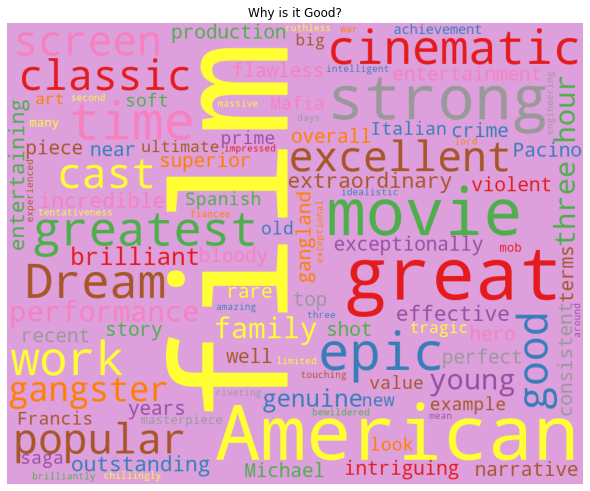

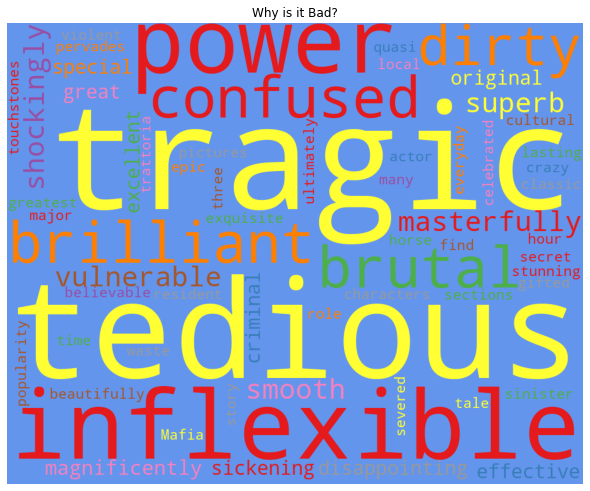

In [265]:
wrd_cloud_pos_neg()

Enter the Movie/Show you want to search for: SCHINDLER'S LIST
Enter for type to search (tv/movie): MOViE
Projected score: 97.65625 
Reviews extracted from Rotten Tomatoes!
Processing for key words...
Vader > Txtblb 1409; Txtblb > Vader 223
All mixed polarity words {'controversial,'}
Model Accuracy: 0.8169014084507042
Obtaining additional short summaries...
Nothing found to extract
Nothing found to extract
Nothing found to extract
Nothing found to extract
Overall Projected Rating
Rotten Tomato: 0.9765625
Bert: 0.7983193277310925


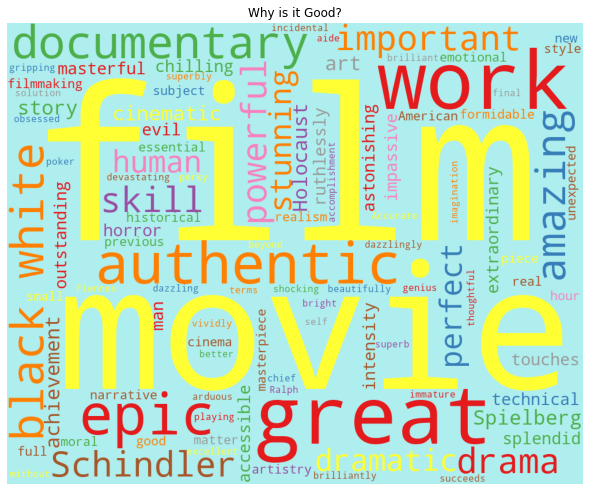

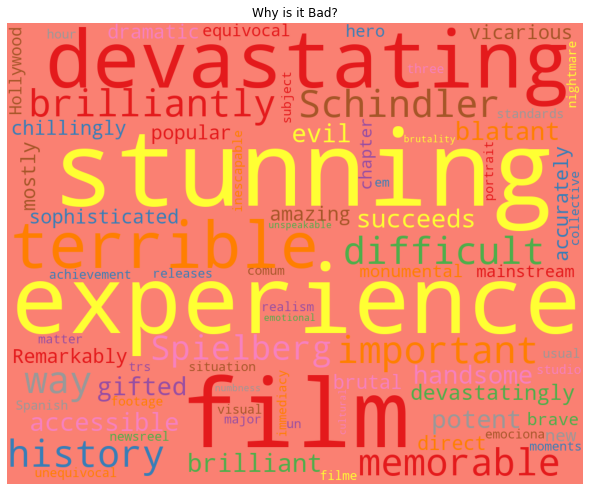

In [267]:
wrd_cloud_pos_neg()

In [254]:
def wrd_cloud_gen(show_url = False, max_wrds = 100):
  from tqdm.notebook import tqdm
  from wordcloud import WordCloud, STOPWORDS
  import matplotlib.pyplot as plt
  import pandas as pd 

  # prompt for movie/show selection
  reviews, labels = extract_movie_reviews(All= True, print_url = show_url)
  
  # key wrd extraction
  key_wrds = []
  for r in tqdm(reviews): 
    key_wrds += extract_key_words_with_temp(r, stop_words, 5, k = 0.1)
  
  # clr template
  clrs = ["paleturquoise", "plum", "lemonchiffon", "lightgreen", "salmon", "lavendar", "cornflowerblue", "navajowhite"]
  clr = np.random.choice(clrs, 1, replace = False)[0]
  
  # wrdcld generation
  wrds_4_cld = " ".join(key_wrds)
  wordcloud = WordCloud(width = 1000, height = 800, random_state=1999, 
                        background_color= clr, colormap='Set1', max_words = max_wrds,
                        collocations=True, stopwords = STOPWORDS.union(stop_words)).generate(wrds_4_cld)

  
  # plot WordCloud                       
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

Enter the Movie/Show you want to search for: wandavision
Enter for type to search (tv/movie): tv
Enter season number (e.g. 01 or None): 01
Projected score: 90.86021505376344 


Sentence of len 8 too short for key word extraction
Sentence of len 8 too short for key word extraction
Sentence of len 4 too short for key word extraction
Sentence of len 9 too short for key word extraction
Sentence of len 7 too short for key word extraction
Sentence of len 8 too short for key word extraction
Sentence of len 2 too short for key word extraction
Sentence of len 4 too short for key word extraction
Sentence of len 4 too short for key word extraction
Sentence of len 7 too short for key word extraction
Sentence of len 7 too short for key word extraction
Sentence of len 5 too short for key word extraction
Not possible to extract 4 words with 3 available



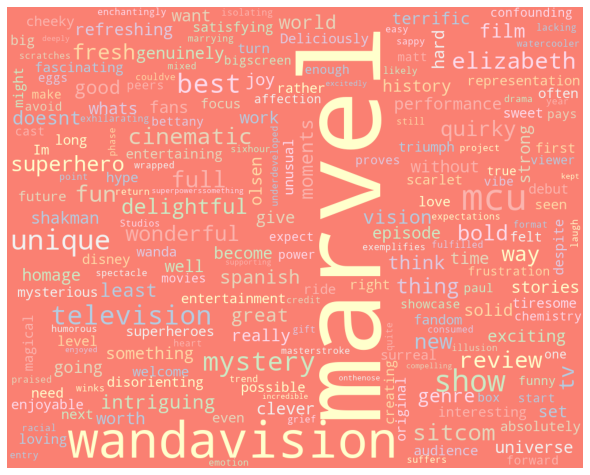

In [168]:
wrd_cloud_gen()

Enter the Movie/Show you want to search for: the godfather
Enter for type to search (tv/movie): movie
Projected score: 96.96969696969697 


Sentence of len 9 too short for key word extraction, using whole review.
Sentence of len 9 too short for key word extraction, using whole review.
Sentence of len 9 too short for key word extraction, using whole review.
Sentence of len 9 too short for key word extraction, using whole review.
Sentence of len 5 too short for key word extraction, using whole review.
Sentence of len 6 too short for key word extraction, using whole review.
Sentence of len 4 too short for key word extraction, using whole review.
Sentence of len 7 too short for key word extraction, using whole review.
Sentence of len 8 too short for key word extraction, using whole review.
Sentence of len 4 too short for key word extraction, using whole review.
Sentence of len 0 too short for key word extraction, using whole review.
Sentence of len 6 too short for key word extraction, using whole review.
Sentence of len 0 too short for key word extraction, using whole review.
Sentence of len 0 too short for key word extraction

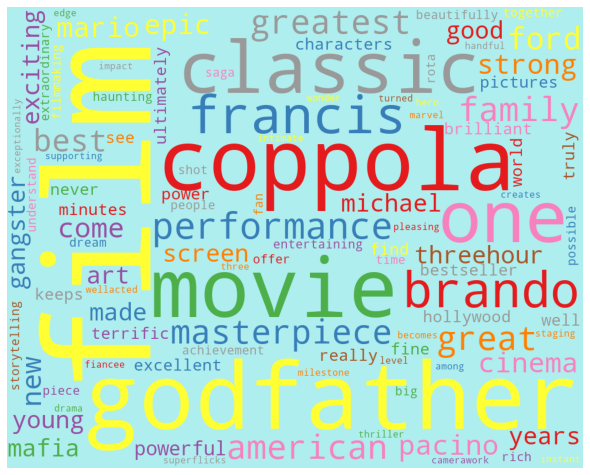

In [186]:
wrd_cloud_gen()

Enter the Movie/Show you want to search for: emily in paris
Enter for type to search (tv/movie): tv
Enter season number (e.g. 01 or None): 01
Projected score: 62.5 


Sentence of len 9 too short for key word extraction, using whole review.



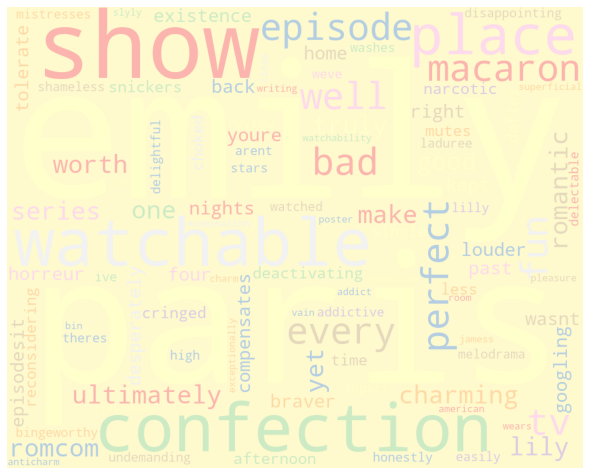

In [180]:
wrd_cloud_gen()

In [ ]:
train_txt[1], train_labels[1]

('not only does leblanc make one spectacularly ugly looking broad , but he appears miserable throughout as he swaggers through his scenes',
 0)

In [ ]:
extract_key_words_with_temp(train_txt[1], stop_words, 5)

['swaggers', 'spectacularly', 'miserable', 'throughout', 'one']

In [ ]:
extract_wrds(test_txt[:20], clf, k = 5)